# Project 4 - What Makes a Good Screenplay? 
------

## Cornell Dataset
Dataset: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

Original Cornell Dataset can be found in `/cornell_corpus`  
Pickles of Cornell Dataset into Pandas Dataframe can be found in `/cornell_corpus_pickles`

## Project Notes

**Original Idea:** Download individual screenplays as PDF, convert to text, and use as documents in corpus  
**Problem:** Screenplays were not all in standard format and converting them to a reasonable format that wasn't just a bag of words was too time consuming for amount of time alloted. 

**Empty Folders:** `/cv`, `/dtm`, `/models`, `/tf` are placeholder folders that were used for batch testing of Topic Modeling

## Future Work

One future work could be name related - 
Names are extremely hard to work with nowadays as it contains a main character and would be a word that shows up extremely often. If it's not in my dictionary, like parasite's names - I'd have to add every instance of it to my stop words.

## Movie References

In [1]:
# m240 +++$+++ american pie +++$+++ 1999 +++$+++ 6.90 +++$+++ 107961 +++$+++ ['comedy', 'romance']
# m117 +++$+++ legally blonde +++$+++ 2001 +++$+++ 6.20 +++$+++ 44558 +++$+++ ['comedy']
# m579 +++$+++ toy story +++$+++ 1995 +++$+++ 8.20 +++$+++ 156231 +++$+++ ['animation', 'adventure', 'comedy', 'family', 'fantasy']
# m574 +++$+++ titanic +++$+++ 1997 +++$+++ 7.40 +++$+++ 244771 +++$+++ ['drama', 'history', 'romance']
# m529 +++$+++ star wars +++$+++ 1977 +++$+++ 8.80 +++$+++ 326619 +++$+++ ['action', 'adventure', 'fantasy', 'sci-fi']
# m253 +++$+++ back to the future +++$+++ 1985 +++$+++ 8.40 +++$+++ 207376 +++$+++ ['adventure', 'family', 'sci-fi']
# m602 +++$+++ what women want +++$+++ 2000 +++$+++ 6.30 +++$+++ 55269 +++$+++ ['comedy', 'fantasy', 'romance']

# Import Statements

In [2]:
import sys
import re
import string
import pickle
import pandas as pd
import numpy as np
from collections import Counter

# Natural Language Pre-Processing
import nltk
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from nltk.chunk import ne_chunk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer 
import spacy
from spacy import displacy
from collections import Counter
from pprint import pprint
import en_core_web_sm
nlp = en_core_web_sm.load()

# Stopwords
from nltk.corpus import stopwords, names
from sklearn.feature_extraction import text

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Matrix Factorization
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans 

# Probabilistic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import matutils, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse

# Visualization
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import umap.umap_ as umap
from yellowbrick.text import UMAPVisualizer

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

font = {'size': 16}

mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = (15,10)

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Default Font Setting for matplotlib graphs
mpl.rcParams['font.family'] = "sans-serif"  # Always use san-serif font
# Always use Futura font for sans-serif
mpl.rcParams['font.sans-serif'] = 'Arial'

/Users/jonathan/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
print(f'Matplot Version: {mpl.__version__}') 
print(f'Seaborn Version: {sns.__version__}')
print(f'Python Version: {sys.version}')

Matplot Version: 3.1.3
Seaborn Version: 0.10.0
Python Version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


# Data Pre-processing
---

## Cornell Data to Dataframe

In [4]:
# movie_lines = pd.read_csv('cornell_corpus/movie_lines.txt',
#                           sep=re.escape(' +++$+++ '), header=None, engine='python')
# movie_lines.columns = ['lineID', 'characterID',
#                        'movieID', 'name', 'text of utterance']

# movie_characters_metadata = pd.read_csv(
#     'cornell_corpus/movie_characters_metadata.txt', sep=re.escape(' +++$+++ '), header=None, engine='python')
# movie_characters_metadata.columns = [
#     'characterID', 'name', 'movieID', 'title', 'gender', 'position in credits']

# movie_conversations = pd.read_csv(
#     'cornell_corpus/movie_conversations.txt', sep=re.escape(' +++$+++ '), header=None, engine='python')
# movie_conversations.columns = ['characterID_1',
#                                'characterID_2', 'movieID', 'list of utterance']

# movie_titles_metadata = pd.read_csv(
#     'cornell_corpus/movie_titles_metadata.txt', sep=re.escape(' +++$+++ '), header=None, engine='python')
# movie_titles_metadata.columns = [
#     'movieID', 'title', 'year', 'IMDBrating', 'numIMDBvotes', 'genres']

In [5]:
# movie_lines.to_pickle("cornell_corpus_pickles/movie_lines.pkl")
# movie_characters_metadata.to_pickle("cornell_corpus_pickles/movie_characters_metadata.pkl")
# movie_conversations.to_pickle("cornell_corpus_pickles/movie_conversations.pkl")
# movie_titles_metadata.to_pickle("cornell_corpus_pickles/movie_titles_metadata.pkl")

In [6]:
movie_lines = pd.read_pickle("cornell_corpus_pickles/movie_lines.pkl")
movie_characters_metadata = pd.read_pickle("cornell_corpus_pickles/movie_characters_metadata.pkl")
movie_conversations = pd.read_pickle("cornell_corpus_pickles/movie_conversations.pkl")
movie_titles_metadata = pd.read_pickle("cornell_corpus_pickles/movie_titles_metadata.pkl")

Since the movie dialogue is segmented per line in order to fabricate the script group together lines by movieID.  
This is a dirty way of doing it, but for the scope of this project, a bag of words should be good enough. 

In [7]:
def dataPreprocess():
    '''Preprocesses the movie lines into a pandas dataframe of movie ID and script (as bag of words)
    Order:
    1. Group movie lines by movie ID into a list
    2. For each movie, turn script into a string
    3. Use SpaCy to remove all Named Entities
    4. Lowercase everything
    5. Remove newlines, excess spaces, punctuation
    6. Lemmatize possible words
    7. Create Pandas Dataframe of ID, script
    8. Return dataframe
    '''
    data = {}
    
    lemmatizer = WordNetLemmatizer() 
    
    movie_text_raw = pd.DataFrame(movie_lines.groupby(
        ['movieID'])['text of utterance'].apply(list))

    for movie, script_raw in movie_text_raw.iterrows():
        # Raw script is a list of dialogs
        script = [x for x in script_raw[0] if x != None] # Remove any strings that contain nothing
        script = ' '.join(script) # Create a string for script
        
        # Spacy sucks - Named Entity Recognition
        script = nlp(script)
        text_no_namedentities = []
        ents = [e.text for e in script.ents]
        for item in script:
            if item.text in ents:
                pass
            else:
                text_no_namedentities.append(item.text)
        script = " ".join(text_no_namedentities)

        # Basic Preprocessing
        script = script.lower()
        script = re.sub(r'\[.*?\]', '', script)
        # script = re.sub(r'\swa\s|\srn\s|\ser\s|\sbr\s|\sos\s', '', script)
        script = re.sub(r'[%s]' % re.escape(string.punctuation), '', script)
        script = re.sub(r'\w*\d\w*', '', script)
        script = re.sub(r'[‘’“”…]', '', script)
        script = re.sub(r'\n', ' ', script)
        script = re.sub(r'\s\s+', ' ', script)
        script = re.sub(r'\s', ' ', script)
        
        # Tokenize script for Lemmatization
        script = word_tokenize(script)
        clean_script = [lemmatizer.lemmatize(word) for word in script]
        final_script = ' '.join(clean_script)
        data[movie] = [final_script]
    
    pd.set_option('max_colwidth', 150)

    data_df = pd.DataFrame(data).transpose()
    data_df.columns = ['script']
    data_df = data_df.sort_index()
    return data_df

In [8]:
# data_df = dataPreprocess()

In [9]:
# data_df.index = data_df.index.map(lambda x: str(x)[1:])
# data_df.index = data_df.index.map(lambda x: int(x))
# data_df.sort_index(inplace=True)

In [10]:
# data_df.to_pickle("dataframes/data_df.pkl")
data_df = pd.read_pickle("dataframes/data_df.pkl")

In [11]:
# data_df = pd.read_pickle("data_df.pkl")

In [12]:
# data_df.to_pickle("data_df_final.pkl")
# data_df = pd.read_pickle("data_df_final.pkl")

In [13]:
# data_df.to_pickle("data_df_final_corrected.pkl")
# data_df = pd.read_pickle("data_df_final_corrected.pkl")

In [14]:
# data_df_TTTT = pd.read_pickle("data_df.pkl")

## EDA

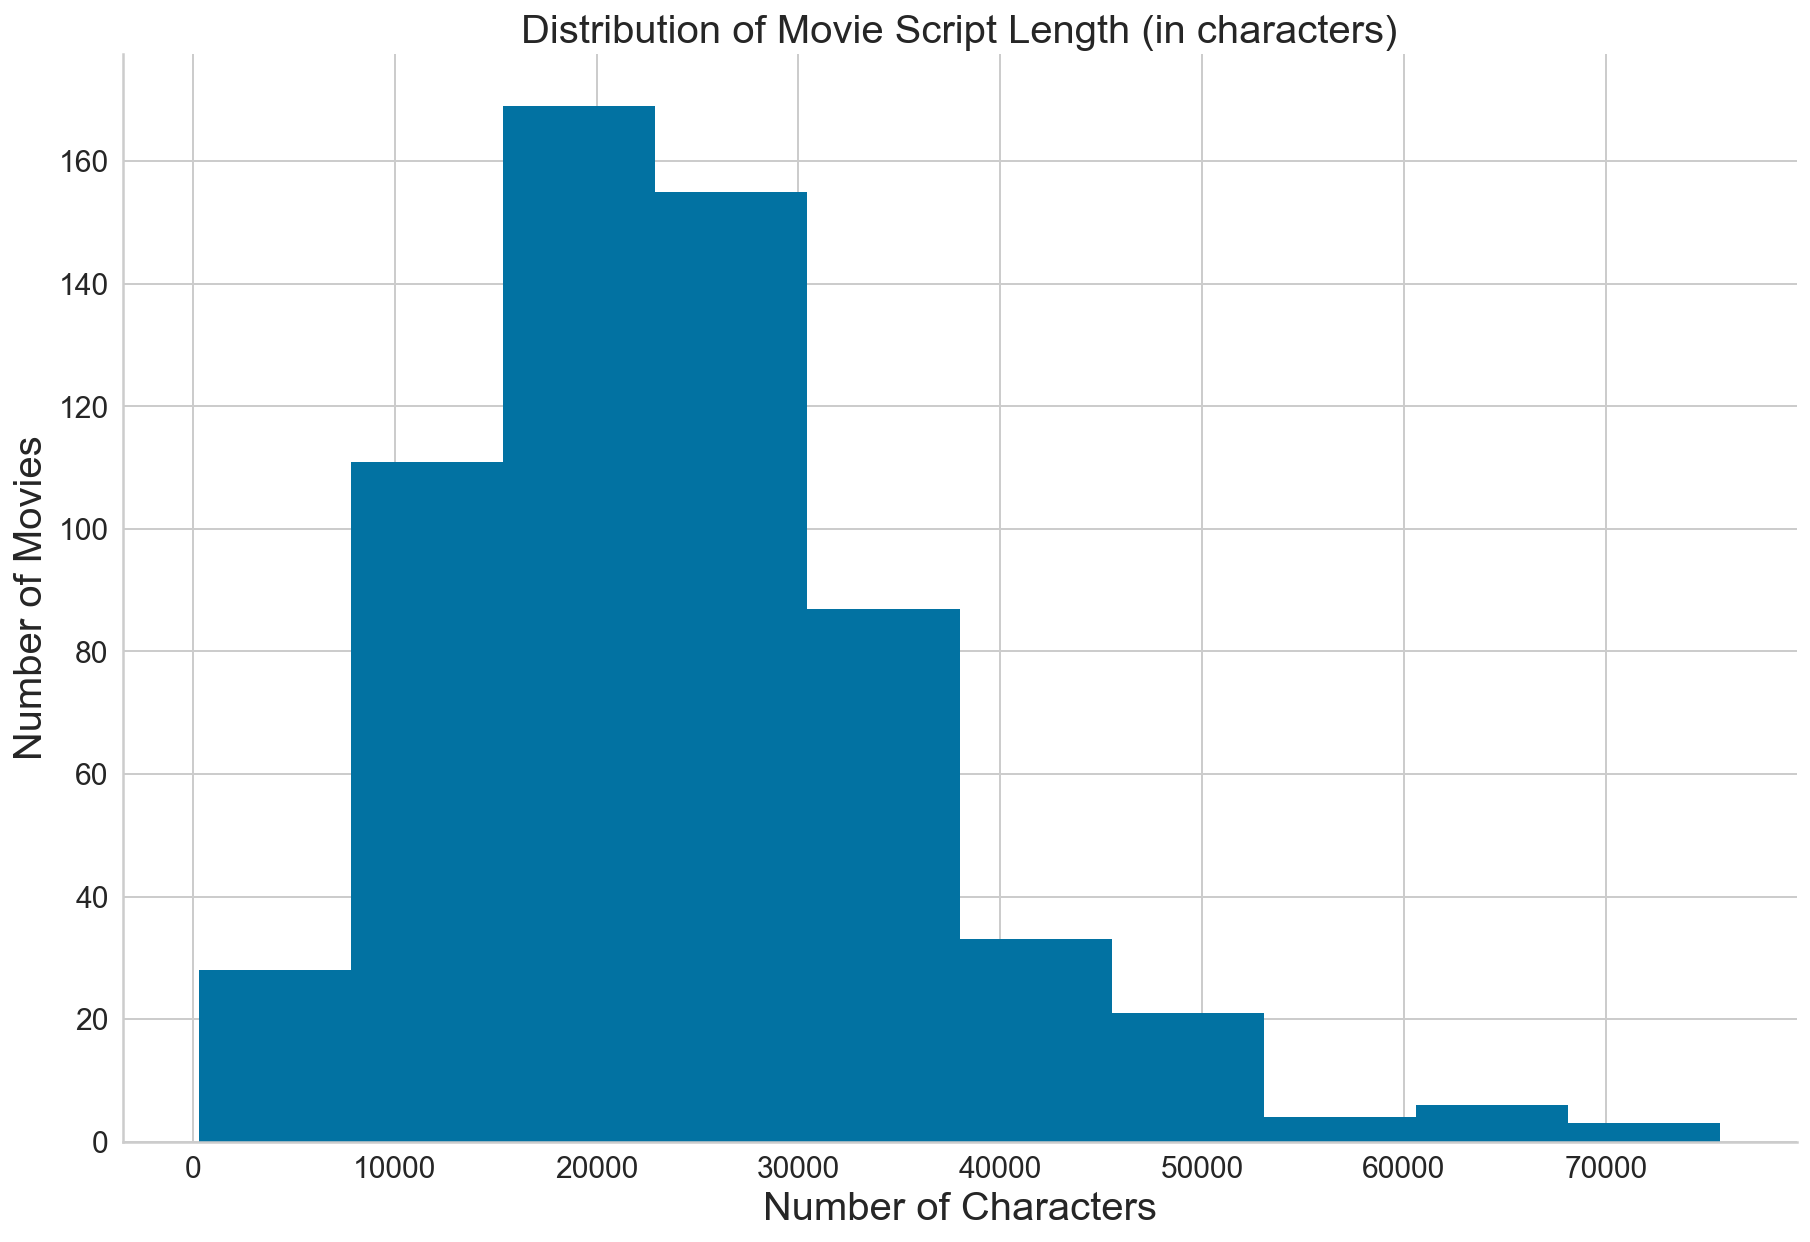

In [15]:
plt.figure(figsize=(15, 10))
doc_lens = [len(d) for d in data_df.script]
doc_titles = [n for n in data_df.index]
docs = list(zip(doc_titles, doc_lens))
plt.hist(doc_lens, bins=10)
plt.title('Distribution of Movie Script Length (in characters)', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Number of Movies', size=20)
plt.xlabel('Number of Characters', size=20)
# plt.xticks(rotation=45, ha='right', visible=False)
sns.despine()
plt.savefig(f'visualizations/distribution_movie_script.png', transparent=True, bbox_inches = 'tight' )

<Figure size 864x864 with 0 Axes>

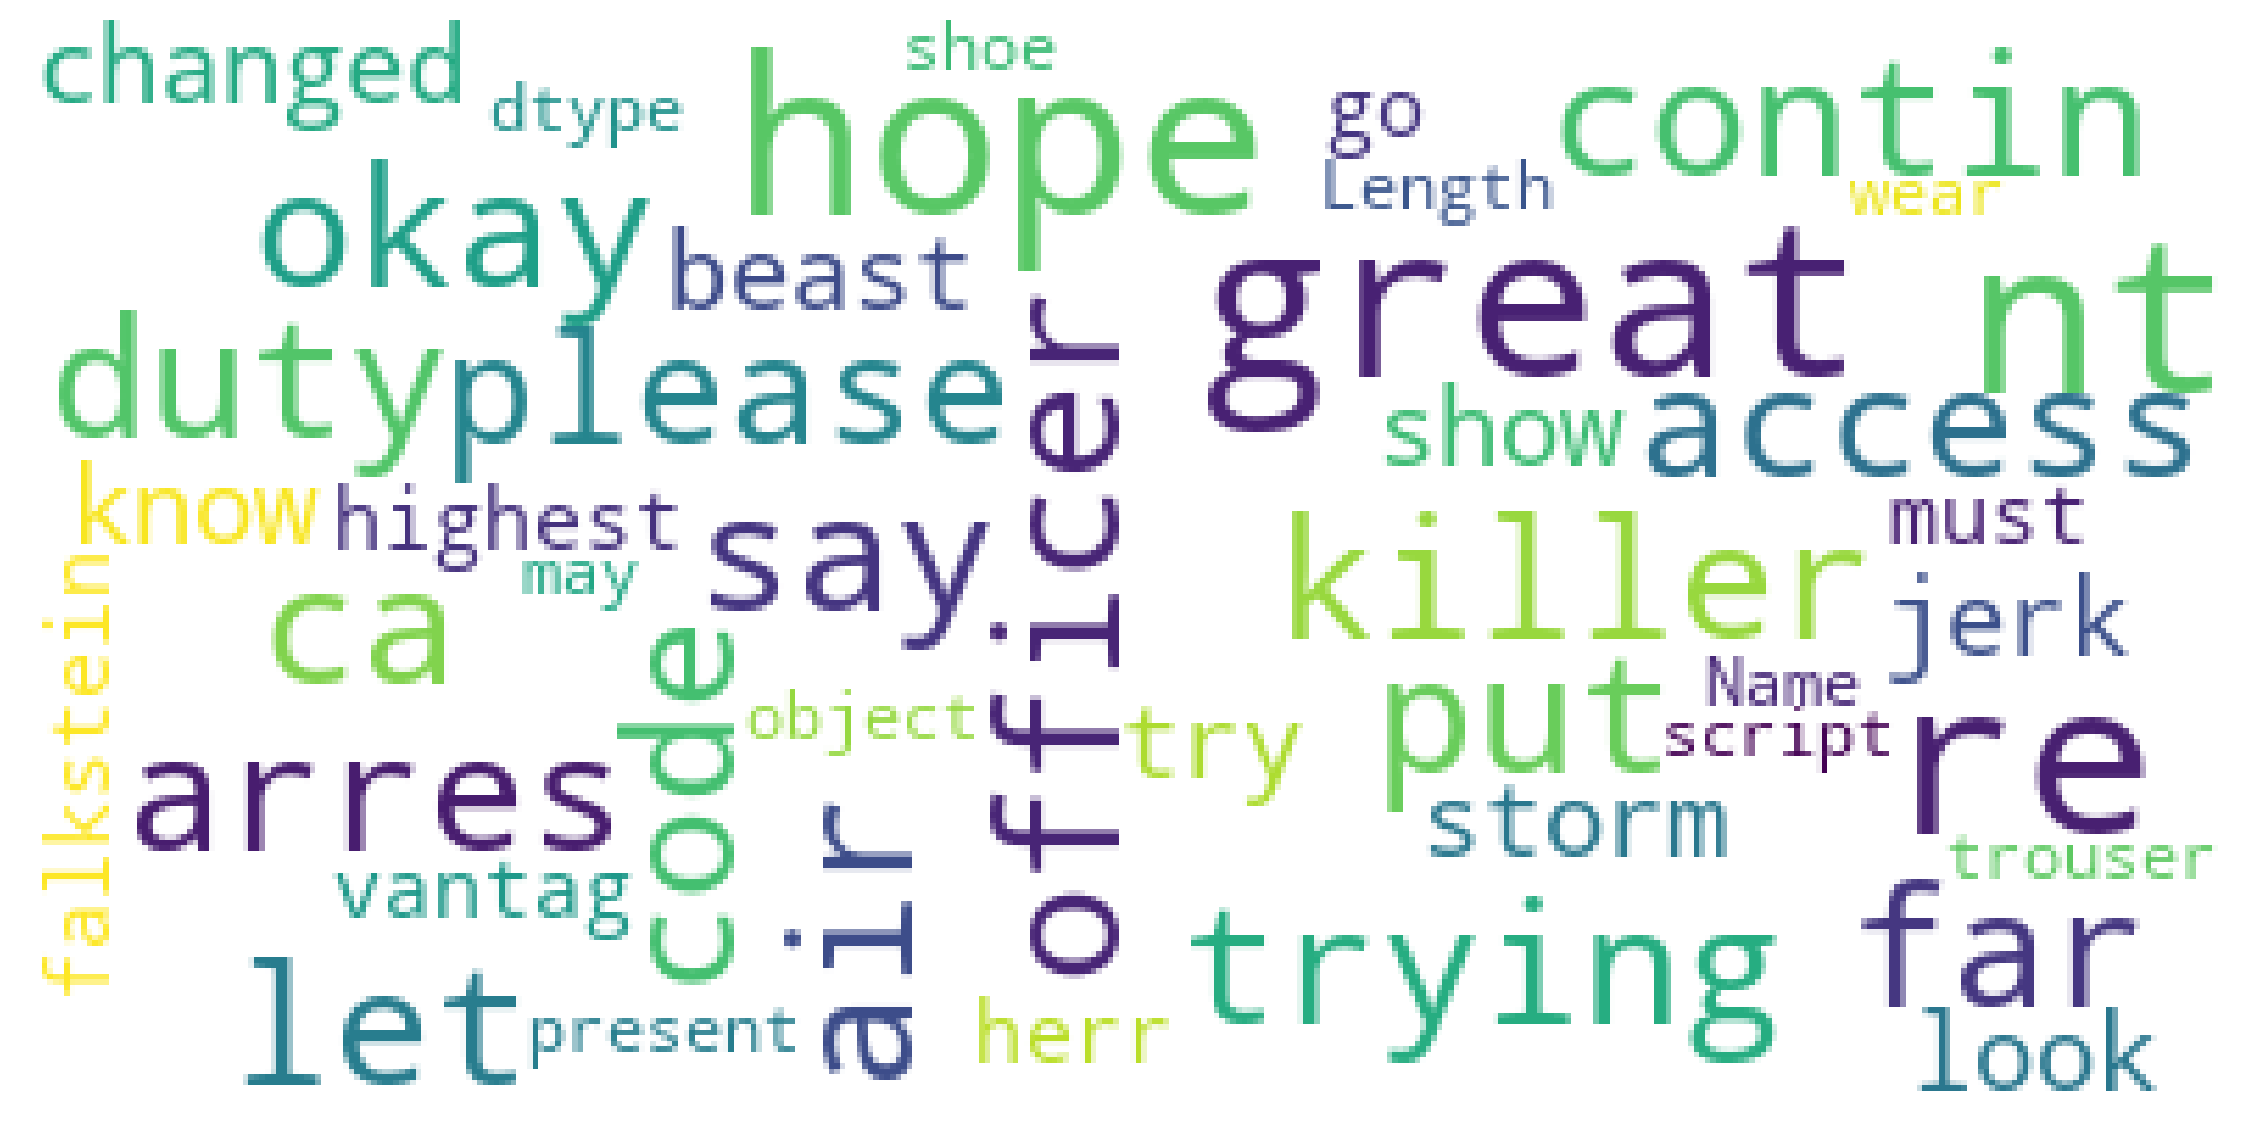

In [16]:
mpl.rcParams['figure.figsize'] = (12.0, 12.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1
cloud_stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=cloud_stopwords,
    max_words=500,
    max_font_size=40,
    random_state=42,
    width=400, height=200
).generate(str(data_df['script']))

print(wordcloud)
fig = plt.figure(1)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig(f'visualizations/word_cloud.png', transparent=True, bbox_inches = 'tight' )
plt.show()

# Topic Modeling

## Helper Functions

In [17]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

## Number of Features and Random State Global Variables

In [18]:
num_features = 9
index_names = [f'component_{x}' for x in range(num_features)]

random_state = 42

## Stopwords

In [19]:
manual_stop = ['do', 'nt', 'dont', 'im', 'know', 'just', 'like', 'youre', 'got', 'want', 
               'thats', 'think', 'right', 'going', 'did', 'oh', 'yeah', 
               'good', 'yes', 'i', 'll', 'm', 'tell', 'hes', 'shell', 'hell', 'okay', 'gon',
              'gonna', 'na', 'uh', 'hi', 'ya', 'ta', 'em', 'wan', 'wanna', 'ok', 'hey', 'ai',
              'wa', 'ca', 'ha', 'mr']

movie_stop = ['ninotchka']

client_prompted = ['luc', 'mar', 'zsa']

nltk_names = [x.lower() for x in list(set(names.words()))]

nltk_stopwords = [x.replace('\'', '') for x in list(stopwords.words('english'))]

In [20]:
manstop = nltk_stopwords + nltk_names + manual_stop + movie_stop + client_prompted
nomanstop = nltk_stopwords + nltk_names + movie_stop + client_prompted

## Vectorizers
Create vectorizers that have variations of the following:
* ngram - unigram, bigram, both
* max_df - variations
* stop_words - standard, custom w/ manual, custom w/o manual

### Count Vectorizer

In [21]:
def createCustomCountVectorizer(df, n_range=(1,1), stop = 'english', min_docfreq = 1, max_docfreq = 1.0, file_mod = ''):
    ''' Creates CV vectorizers, makes a document-term matrix using vectorizer and pickles both
    Arguments:
    df -- df to fit vectorizer on
    n_range -- What type of n-grams to use (default unigram only (1,1))
    stop -- stop words options are man (w/ manual) and noman (w/o manual) (default 'english')
    min_docfreq -- ignore terms that have a document frequency strictly 
                    lower than the given threshold.  (default 1)
    max_docfreq -- ignore terms that have a document frequency 
                    strictly higher than given threshold  (default 1.0)
    file_mod -- string to modify pickle file names
    '''
    if stop == 'man':
        stopwords = manstop
    elif stop == 'noman':
        stopwords = nomanstop
    else:
        stopwords = 'english'
        
    cv = CountVectorizer(ngram_range = n_range, stop_words = stopwords, min_df = min_docfreq, max_df = max_docfreq)
    data_dtm = cv.fit_transform(df.script)
    data_dtm = pd.DataFrame(data_dtm.toarray(),
                              columns=cv.get_feature_names())
    data_dtm.index = df.index
    
    return cv, data_dtm

**Very Storage Intensive to Run, only used when initally testing a variety of models**

In [22]:
def createCountVectorizer(df, n_range=(1,1), stop = 'english', min_docfreq = 1, max_docfreq = 1.0, file_mod = ''):
    ''' Creates CV vectorizers, makes a document-term matrix using vectorizer and pickles both
    Arguments:
    df -- df to fit vectorizer on
    n_range -- What type of n-grams to use (default unigram only (1,1))
    stop -- stop words options are man (w/ manual) and noman (w/o manual) (default 'english')
    min_docfreq -- ignore terms that have a document frequency strictly 
                    lower than the given threshold.  (default 1)
    max_docfreq -- ignore terms that have a document frequency 
                    strictly higher than given threshold  (default 1.0)
    file_mod -- string to modify pickle file names
    '''
    if stop == 'man':
        stopwords = manstop
    elif stop == 'noman':
        stopwords = nomanstop
    else:
        stopwords = 'english'
        
    cv = CountVectorizer(ngram_range = n_range, stop_words = stopwords, min_df = min_docfreq, max_df = max_docfreq)
    data_dtm = cv.fit_transform(df.script)
    data_dtm = pd.DataFrame(data_dtm.toarray(),
                              columns=cv.get_feature_names())
    data_dtm.index = df.index
    
    with open(f'cv/cv{file_mod}_{n_range}_{stop}_{min_docfreq}_{max_docfreq}.pkl', 'wb' ) as handle:
        pickle.dump(cv, handle)
    data_dtm.to_pickle(f'dtm/dtm_cv{file_mod}_{n_range}_{stop}_{min_docfreq}_{max_docfreq}.pkl')

In [23]:
def createCV(max_df):
    createCountVectorizer(data_df, n_range = (1,1), stop='man', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (1,2), stop='man', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (2,2), stop='man', max_docfreq = max_df)
    
    createCountVectorizer(data_df, n_range = (1,1), stop='noman', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (1,2), stop='noman', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (2,2), stop='noman', max_docfreq = max_df)
    
    createCountVectorizer(data_df, n_range = (1,1), stop='english', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (1,2), stop='english', max_docfreq = max_df)
    createCountVectorizer(data_df, n_range = (2,2), stop='english', max_docfreq = max_df)
    
# createCV(1.0)
# createCV(0.9)
# createCV(0.85)

In [24]:
def createRatingCV(max_df):
    createCountVectorizer(df_bad, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_bad')
    createCountVectorizer(df_bad, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_bad')
    createCountVectorizer(df_bad, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_bad')
    createCountVectorizer(df_bad, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_bad')
    
    createCountVectorizer(df_neutral, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_neutral')
    createCountVectorizer(df_neutral, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_neutral')
    createCountVectorizer(df_neutral, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_neutral')
    createCountVectorizer(df_neutral, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_neutral')
    
    createCountVectorizer(df_good, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_good')
    createCountVectorizer(df_good, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_good')
    createCountVectorizer(df_good, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_good')
    createCountVectorizer(df_good, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_good')
    
# createRatingCV(1.0)
# createRatingCV(0.9)
# createRatingCV(0.85)

In [25]:
# with open('cv/cv_(1, 1)_noman_1.0.pkl', 'rb') as handle:
#     cv_1_noman_100 = pickle.load(handle)
# dtm_cv_1_noman_100 = pd.read_pickle('dtm/dtm_cv_(1, 1)_noman_1.0.pkl')
    
# with open('cv/cv_(1, 2)_noman_1.0.pkl', 'rb') as handle:
#     cv_12_noman_100 = pickle.load(handle) 
# dtm_cv_12_noman_100 = pd.read_pickle('dtm/dtm_cv_(1, 2)_noman_1.0.pkl')

# with open('cv/cv_(2, 2)_noman_1.0.pkl', 'rb') as handle:
#     cv_2_noman_100 = pickle.load(handle)
# dtm_cv_2_noman_100 = pd.read_pickle('dtm/dtm_cv_(2, 2)_noman_1.0.pkl')

In [26]:
# cv1 = CountVectorizer(ngram_range=(1, 1), stop_words=stop, max_df = 0.85)
# data_dtm_1 = cv1.fit_transform(data_df.script)
# data_dtm_1 = pd.DataFrame(data_dtm_1.toarray(),
#                           columns=cv1.get_feature_names())
# data_dtm_1.index = data_df.index

In [27]:
# cv2 = CountVectorizer(ngram_range=(2, 2), stop_words=stop, max_df = 0.85) # maybe the max_df is too low here 
# data_dtm_2 = cv2.fit_transform(data_df.script)
# data_dtm_2 = pd.DataFrame(data_dtm_2.toarray(),
#                           columns=cv2.get_feature_names())
# data_dtm_2.index = data_df.index

In [28]:
# cv12 = CountVectorizer(ngram_range=(1, 2), stop_words=stop, max_df = 0.85)
# data_dtm_12 = cv12.fit_transform(data_df.script)
# data_dtm_12 = pd.DataFrame(data_dtm_12.toarray(),
#                            columns=cv12.get_feature_names())
# data_dtm_12.index = data_df.index

### TF-IDF

In [29]:
def createCustomTFIDFvectorizer(df, n_range=(1,1), stop = 'english', min_docfreq = 1, max_docfreq = 1.0, file_mod = ''):
    ''' Creates TF-IDF vectorizers, makes a document-term matrix using vectorizer and pickles both
    Arguments:
    df -- df to fit vectorizer on
    n_range -- What type of n-grams to use (default unigram only (1,1))
    stop -- stop words options are man (w/ manual) and noman (w/o manual) (default 'english')
    min_docfreq -- ignore terms that have a document frequency strictly 
                lower than the given threshold.  (default 1)
    max_docfreq -- ignore terms that have a document frequency 
                    strictly higher than given threshold  (default 1.0)
            
    file_mod -- string to modify pickle file names
    '''
    if stop == 'man':
        stopwords = manstop
    elif stop == 'noman':
        stopwords = nomanstop
    else:
        stopwords = 'english'
        
    tf = TfidfVectorizer(ngram_range = n_range, stop_words = stopwords, max_df = max_docfreq)
    data_dtm = tf.fit_transform(df.script)
    data_dtm = pd.DataFrame(data_dtm.toarray(),
                              columns=tf.get_feature_names())
    data_dtm.index = df.index

    return tf, data_dtm

**Very Storage Intensive to Run, only used when initally testing a variety of models**

In [30]:
def createTFIDFvectorizer(df, n_range=(1,1), stop = 'english', max_docfreq = 1.0, file_mod = ''):
    ''' Creates TF-IDF vectorizers, makes a document-term matrix using vectorizer and pickles both
    Arguments:
    df -- df to fit vectorizer on
    n_range -- What type of n-grams to use (default unigram only (1,1))
    stop -- stop words options are man (w/ manual) and noman (w/o manual) (default 'english')
    max_docfreq -- ignore terms that have a document frequency 
                    strictly higher than given threshold  (default 1.0)
    file_mod -- string to modify pickle file names
    '''
    if stop == 'man':
        stopwords = manstop
    elif stop == 'noman':
        stopwords = nomanstop
    else:
        stopwords = 'english'
        
    tf = TfidfVectorizer(ngram_range = n_range, stop_words = stopwords, max_df = max_docfreq)
    data_dtm = tf.fit_transform(df.script)
    data_dtm = pd.DataFrame(data_dtm.toarray(),
                              columns=tf.get_feature_names())
    data_dtm.index = df.index
    
    with open(f'tf/tf{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'wb' ) as handle:
        pickle.dump(tf, handle)
    data_dtm.to_pickle(f'dtm/dtm_tf{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl')

In [31]:
def createTFIDF(max_df):
    createTFIDFvectorizer(data_df, n_range = (1,1), stop='man', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (1,2), stop='man', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (2,2), stop='man', max_docfreq = max_df)
    
    createTFIDFvectorizer(data_df, n_range = (1,1), stop='noman', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (1,2), stop='noman', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (2,2), stop='noman', max_docfreq = max_df)
    
    createTFIDFvectorizer(data_df, n_range = (2,2), stop='english', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (2,2), stop='english', max_docfreq = max_df)
    createTFIDFvectorizer(data_df, n_range = (2,2), stop='english', max_docfreq = max_df)
    
# createTFIDF(1.0)
# createTFIDF(0.9)
# createTFIDF(0.85)

In [32]:
def createRatingTFIDF(max_df):
    createTFIDFvectorizer(df_bad, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_bad')
    createTFIDFvectorizer(df_bad, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_bad')
    createTFIDFvectorizer(df_bad, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_bad')
    createTFIDFvectorizer(df_bad, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_bad')
    
    createTFIDFvectorizer(df_neutral, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_neutral')
    createTFIDFvectorizer(df_neutral, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_neutral')
    createTFIDFvectorizer(df_neutral, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_neutral')
    createTFIDFvectorizer(df_neutral, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_neutral')
    
    createTFIDFvectorizer(df_good, n_range = (1,1), stop='noman', max_docfreq = max_df, file_mod = '_good')
    createTFIDFvectorizer(df_good, n_range = (2,2), stop='noman', max_docfreq = max_df, file_mod = '_good')
    createTFIDFvectorizer(df_good, n_range = (1,1), stop='english', max_docfreq = max_df, file_mod = '_good')
    createTFIDFvectorizer(df_good, n_range = (2,2), stop='english', max_docfreq = max_df, file_mod = '_good')
    
    
# createRatingTFIDF(1.0)
# createRatingTFIDF(0.9)
# createRatingTFIDF(0.85)

## LSA

### Custom LSA

In [33]:
def performCustomLSA(vec, dtm, num_features = num_features, index_names = index_names):
    '''
    Arguments:
    vectorizer -- 'cv' or 'tfidf'
    n_range -- '(1, 1)', '(1, 2)', or '(2, 2)'
    stop -- 'english', 'noman' or 'man'
    max_docfreq -- 0.8, 1.0 (depends)
    file_mod -- allows for rating file access: '_bad', '_neutral', or '_good'
    '''
    lsa = TruncatedSVD(n_components = num_features, random_state = random_state)
    doc_topic_lsa = lsa.fit_transform(dtm)
    print('The explained variance is:')
    print(lsa.explained_variance_ratio_)
    
    topic_word = pd.DataFrame(lsa.components_.round(3),
                           index=index_names,
                           columns=vec.get_feature_names())
    print('---')
    print('The topics are:')
    display_topics(lsa, vec.get_feature_names(), 20)
    
    best_topic_lsa = [x.argmax() for x in doc_topic_lsa]
    
    # UMAP Visualization Option 1 -------------------------------------------
    docs = doc_topic_lsa
    labels = best_topic_lsa

    umap = UMAPVisualizer(metric ='euclidean')
    umap.fit(docs, labels)
    umap.show()
    
    
    # UMAP Visualization Option 2 -------------------------------------------
#     embedding_lsa = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(doc_topic_lsa)

#     plt.figure(figsize=(7,5))
#     plt.scatter(embedding_lsa[:, 0], embedding_lsa[:, 1],
#                 s = 10, # size
#                 edgecolor='none',
#                 c = best_topic_lsa,
#                 cmap='Set1'
#                 )
#     plt.show()

### Batch LSA

In [34]:
def performLSA(vectorizer, n_range, stop, max_docfreq, file_mod = ''):
    '''
    Arguments:
    vectorizer -- 'cv' or 'tfidf'
    n_range -- '(1, 1)', '(1, 2)', or '(2, 2)'
    stop -- 'english', 'noman' or 'man'
    max_docfreq -- 0.8, 1.0 (depends)
    file_mod -- allows for rating file access: '_bad', '_neutral', or '_good'
    '''
    with open(f'{vectorizer}/{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'rb') as handle:
        vec = pickle.load(handle)
    dtm = pd.read_pickle(f'dtm/dtm_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl')
    
    lsa = TruncatedSVD(num_features)
    doc_topic_lsa = lsa.fit_transform(dtm)
    print(f'LSA using {vectorizer}, with n_gram of {n_range}, stop words of {stop}, and max_df of {max_docfreq}')
    print('The explained variance is:')
    print(lsa.explained_variance_ratio_)
    
    topic_word = pd.DataFrame(lsa.components_.round(3),
                           index=index_names,
                           columns=vec.get_feature_names())
    print('---')
    print('The topics are:')
    display_topics(lsa, vec.get_feature_names(), 20)
    
    with open(f'models/lsa_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'wb') as handle:
        pickle.dump(lsa, handle)
    
    best_topic_lsa = [x.argmax() for x in doc_topic_lsa]
    
    # UMAP Visualization Option 1 -------------------------------------------
    docs = doc_topic_lsa
    labels = best_topic_lsa

    umap = UMAPVisualizer(metric ='euclidean')
    umap.fit(docs, labels)
    umap.show()
    
    # UMAP Visualization Option 2 -------------------------------------------
#     embedding_lsa = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(doc_topic_lsa)

#     plt.figure(figsize=(7,5))
#     plt.scatter(embedding_lsa[:, 0], embedding_lsa[:, 1],
#                 s = 10, # size
#                 edgecolor='none',
#                 c = best_topic_lsa,
#                 cmap='Set1'
#                 )
#     plt.show()

### Testing LSA Code

In [35]:
# lsa1 = TruncatedSVD(num_features)
# doc_topic_lsa1 = lsa1.fit_transform(data_dtm_1)
# lsa1.explained_variance_ratio_

In [36]:
# topic_word1 = pd.DataFrame(lsa1.components_.round(3),
#                            index=index_names,
#                            columns=cv1.get_feature_names())
# topic_word1

In [37]:
# display_topics(lsa1, cv1.get_feature_names(), 20)

In [38]:
# best_topic_lsa1 = [x.argmax() for x in doc_topic_lsa1]

In [39]:
# embedding_lsa1 = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(doc_topic_lsa1)

# plt.figure(figsize=(7,5))
# plt.scatter(embedding_lsa1[:, 0], embedding_lsa1[:, 1],
#             s = 10, # size
#             edgecolor='none',
#             c = best_topic_lsa1,
#             cmap='Set1'
#             )
# plt.show()

In [40]:
# t0 = [x[0] for x in doc_topic_lsa]
# avg_t = []
# for i in range(20):
#     t0 = [x[i] for x in doc_topic_lsa]
#     avg_t.append(t0)

# mean_topic_lsa = [np.mean(x) for x in avg_t]

In [41]:
# np.mean(doc_topic_lsa, axis=0)

In [42]:
# Counter(best_topic_lsa)

In [43]:
# Counter(mean_topic_lsa)

**These don't work if pickles aren't made using batch vectorizer creators - createCV, createRatingCV, createTFIDF, or createRatingTFIDF**

### CV | Unigram | Custom No Manual Stop Words | 1.0

In [44]:
# performLSA(vectorizer = 'cv', n_range = '(1, 1)', stop = 'noman', max_docfreq = '1.0')

### CV | Bigram | Standard Stop Words | 1.0

In [45]:
# performLSA(vectorizer = 'cv', n_range = '(2, 2)', stop = 'english', max_docfreq = '1.0')

### TF-IDF | Unigram | Custom Manual Stop Words | 0.85

In [46]:
# performLSA(vectorizer = 'tf', n_range = '(1, 1)', stop = 'man', max_docfreq = '0.85')

### TF-IDF | Bigram | Standard Stop Words | 1.0

In [47]:
# performLSA(vectorizer = 'tf', n_range = '(2, 2)', stop = 'english', max_docfreq = '1.0')

## NMF

### Custom NMF

In [48]:
def performCustomNMF(vec, dtm, num_features = num_features, index_names = index_names):
    nmf_model = NMF(n_components = num_features, random_state = random_state)
    doc_topic_nmf = nmf_model.fit_transform(dtm)
    
    print('The mean of individual topic weights over all documents is:')
    mean = np.mean(doc_topic_nmf, axis=0)
    print(mean)
    
    print('---')
    print('The variance of individual topic weights over all documents is:')
    variance = np.var(doc_topic_nmf, axis=0)
    print(variance)
    
    topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                  index=index_names,
                                  columns=vec.get_feature_names())
    print('---')
    print('The topics are:')
    display_topics(nmf_model, vec.get_feature_names(), 60)
    
    return_doc_topic_nmf = doc_topic_nmf.copy()
    kmeans = KMeans(n_clusters=num_features, random_state=random_state).fit(doc_topic_nmf)
    cluster_topic_nmf = kmeans.labels_
    best_topic_nmf = [x.argmax() for x in doc_topic_nmf]
    
    # UMAP Visualization Option 1 -------------------------------------------
    plt.figure(figsize=(15,10))
    docs = doc_topic_nmf
    labels = best_topic_nmf

    umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1', random_state=random_state)
    umap.fit(docs, labels)
    umap.show()
    

    # UMAP Visualization Option 2 -------------------------------------------
#     embedding = umap.UMAP(n_neighbors=500, min_dist=0.5, random_state=12).fit_transform(doc_topic_nmf)
#     # more neighbors is more globally interpretable
    
#     plt.figure(figsize=(15,10))
#     plt.scatter(cc[:, 0], cc[:, 1], c='black')
#     plt.scatter(embedding[:, 0], embedding[:, 1],
#                 s = 200, # size
#                 edgecolor='none',
#                 c = best_topic_nmf,
#                 cmap='Set1'
#                 )
#     plt.show()

    return return_doc_topic_nmf

### Batch NMF

In [49]:
def performNMF(vectorizer, n_range, stop, max_docfreq, file_mod = ''):
    '''
    Arguments:
    vectorizer -- 'cv' or 'tfidf'
    n_range -- '(1, 1)', '(1, 2)', or '(2, 2)'
    stop -- 'english', 'noman' or 'man'
    max_docfreq -- 0.8, 1.0 (depends)
    file_mod -- allows for rating file access: '_bad', '_neutral', or '_good'
    '''
    with open(f'{vectorizer}/{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'rb') as handle:
        vec = pickle.load(handle)
    dtm = pd.read_pickle(f'dtm/dtm_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl')
    
    nmf_model = NMF(n_components = num_features, random_state = random_state)
    doc_topic_nmf = nmf_model.fit_transform(dtm)
    
    print(f'NMF using {vectorizer}, with n_gram of {n_range}, stop words of {stop}, and max_df of {max_docfreq}')
    
    print('The mean of individual topic weights over all documents is:')
    mean = np.mean(doc_topic_nmf, axis=0)
    print(mean)
    
    print('---')
    print('The variance of individual topic weights over all documents is:')
    variance = np.var(doc_topic_nmf, axis=0)
    print(variance)
    
    topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                  index=index_names,
                                  columns=vec.get_feature_names())
    print('---')
    print('The topics are:')
    display_topics(nmf_model, vec.get_feature_names(), 20)
    
    with open(f'models/nmf_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'wb') as handle:
        pickle.dump(nmf_model, handle)
        
    best_topic_nmf = [x.argmax() for x in doc_topic_nmf]
    
    
    
    # UMAP Visualization Option 1 -------------------------------------------
    plt.figure(figsize=(15,10))
    docs = doc_topic_nmf
    labels = best_topic_nmf

    umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1')
    umap.fit(docs, labels)
    umap.show()

    # UMAP Visualization Option 2 -------------------------------------------
#     embedding = umap.UMAP(n_neighbors=500, min_dist=0.5, random_state=12).fit_transform(doc_topic_nmf)
#     # more neighbors is more globally interpretable

#     plt.figure(figsize=(15,10))
#     plt.scatter(embedding[:, 0], embedding[:, 1],
#                 s = 200, # size
#                 edgecolor='none',
#                 c = best_topic_nmf,
#                 cmap='Set1'
#                 )
#     plt.show()

    return doc_topic_nmf

### Testing NMF Code

In [50]:
# nmf_model = NMF(num_features)
# doc_topic_nmf = nmf_model.fit_transform(data_dtm_1)

In [51]:
# topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
#                               index=index_names,
#                               columns=cv1.get_feature_names())
# topic_word_nmf

In [52]:
# display_topics(nmf_model, cv1.get_feature_names(), 20)

In [53]:
# best_topic_nmf = [x.argmax() for x in doc_topic_nmf]
# Counter(best_topic_nmf)

In [54]:
# # X_topics = lsa.fit_transform(X)
# embedding = umap.UMAP(n_neighbors=500, min_dist=0.5, random_state=12).fit_transform(doc_topic_nmf)
# # more neighbors is more globally interpretable


# plt.figure(figsize=(15,10))
# plt.scatter(embedding[:, 0], embedding[:, 1],
#             s = 200, # size
#             edgecolor='none',
#             c = best_topic_nmf,
#             cmap='Set1'
#             )
# plt.show()

**These don't work if pickles aren't made using batch vectorizer creators - createCV, createRatingCV, createTFIDF, or createRatingTFIDF**

### CV | Unigram | Custom No Manual Stop Words | 1.0

In [55]:
# doc_topic_nmf = performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'noman', max_docfreq = '1.0')

### CV | Bigram | Standard Stop Words | 1.0

In [56]:
# performNMF(vectorizer = 'cv', n_range = '(2, 2)', stop = 'english', max_docfreq = '1.0')

### CV | Unigram | Custom Manual Stop Words | 0.85

In [57]:
# performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'man', max_docfreq = '0.85')

### CV | Unigram | Standard Stop Words | 0.85

In [58]:
# doc_topic_nmf_selection = performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'english', max_docfreq = '0.85')

### CV | Unigram and Bigram | Custom Manual Stop Words | 0.85

In [59]:
# performNMF(vectorizer = 'cv', n_range = '(1, 2)', stop = 'man', max_docfreq = '0.85')

### TF-IDF | Unigram | Custom Manual Stop Words | 0.85

In [60]:
# performNMF(vectorizer = 'tf', n_range = '(1, 1)', stop = 'man', max_docfreq = '0.85')

### CHOSEN FOR TOPIC MODELING - TF-IDF | Unigram | Custom Manual Stop Words | 0.85

The mean of individual topic weights over all documents is:
[0.04486543 0.01977019 0.03958339 0.0472138  0.02966    0.04129049
 0.03041578 0.02334677 0.03193241]
---
The variance of individual topic weights over all documents is:
[0.00235081 0.00243924 0.00222384 0.00376316 0.00327746 0.00329657
 0.00254849 0.00244008 0.00327187]
---
The topics are:

Topic  0
school, great, mom, home, kid, house, god, guess, thanks, baby, nice, year, girl, big, night, mother, fine, huh, movie, dad, party, actually, parent, stuff, someone, married, remember, woman, wanted, date, pretty, real, hello, show, sex, father, wow, story, dream, stop, trying, class, talking, book, getting, dinner, listen, um, person, alright, anyway, together, thank, whole, thinking, minute, play, fun, room, hate

Topic  1
ship, admiral, enterprise, commander, planet, crew, power, space, system, sir, shield, boat, warp, beam, command, signal, control, vessel, aboard, computer, torpedo, engine, data, mission, unit, radiation, tra

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

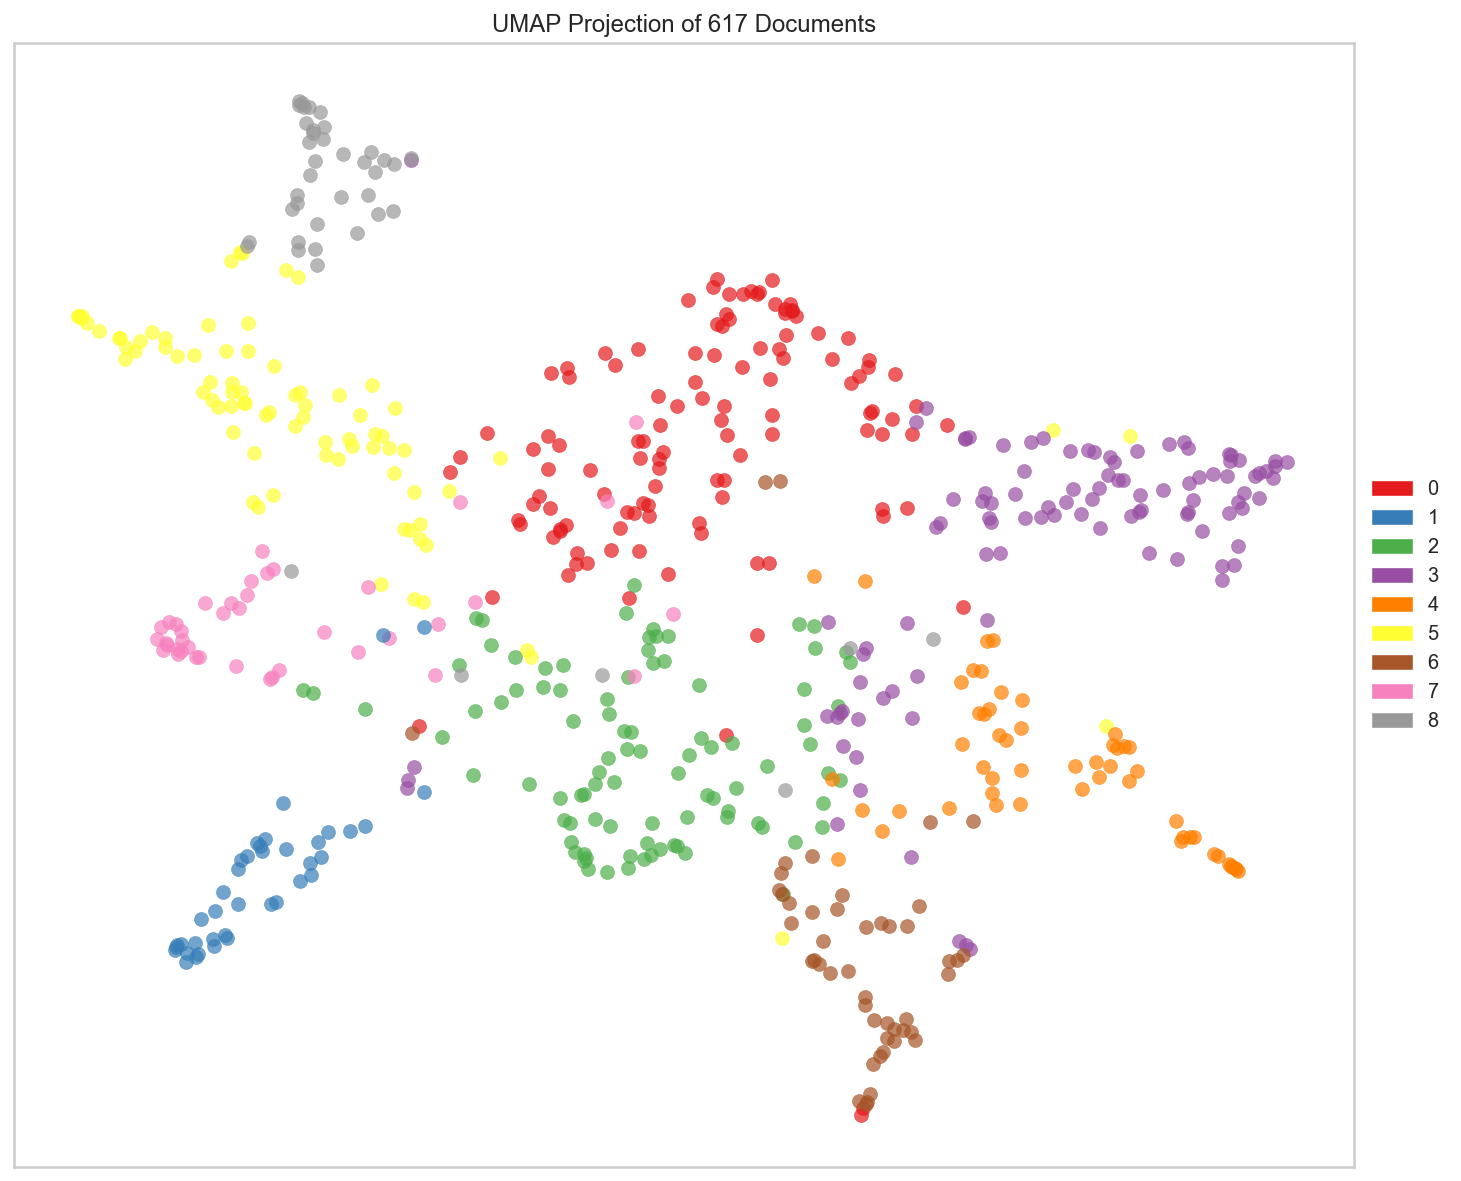

617

In [61]:
tf, dtm = createCustomTFIDFvectorizer(data_df, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.85, file_mod = '')

index_names = [f'component_{x}' for x in range(9)]
doc_topic_nmf_chosen = performCustomNMF(tf, dtm, num_features = 9, index_names = index_names)

len(doc_topic_nmf_chosen)

### NMF Analysis

In [62]:
doc_topic_nmf_chosen
best_topic_nmf_chosen = [x.argmax() for x in doc_topic_nmf_chosen]

In [63]:
len(best_topic_nmf_chosen)

617

In [64]:
movie_nmf = movie_titles_metadata.copy()

In [65]:
movie_nmf['genres'] = movie_nmf['genres'].str.replace(" ", "")
movie_nmf['genres'] = movie_nmf['genres'].str[1:-1]
movie_nmf['genres'] = movie_nmf['genres'].str.split(',')
movie_nmf['genres'] = movie_nmf['genres'].apply(list)

In [66]:
movie_nmf.year.apply(int)

0      1999
1      1992
2      2001
3      1968
4      1982
       ... 
612    2009
613    2002
614    2000
615    1974
616    1979
Name: year, Length: 617, dtype: int64

In [67]:
movie_nmf

,movieID,title,year,IMDBrating,numIMDBvotes,genres
0,m0,10 things i hate about you,1999,6.9,62847,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,1992,6.2,10421,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,2001,6.1,25854,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,1968,8.4,163227,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,1982,6.9,22289,"['action', 'comedy', 'crime', 'drama', 'thrill..."
...,...,...,...,...,...,...
612,m612,watchmen,2009,7.8,135229,"['action', 'crime', 'fantasy', 'mystery', 'sci..."
613,m613,xxx,2002,5.6,53505,"['action', 'adventure', 'crime']"
614,m614,x-men,2000,7.4,122149,"['action', 'sci-fi']"
615,m615,young frankenstein,1974,8.0,57618,"['comedy', 'sci-fi']"


In [68]:
movie_nmf['nmf_topic'] = best_topic_nmf_chosen

Looking at statistics for specific topics

In [69]:
# movie_nmf_0 = movie_nmf[movie_nmf['nmf_topic'] == 0].copy()
# movie_nmf_1 = movie_nmf[movie_nmf['nmf_topic'] == 1].copy()
# movie_nmf_2 = movie_nmf[movie_nmf['nmf_topic'] == 2].copy()
# movie_nmf_3 = movie_nmf[movie_nmf['nmf_topic'] == 3].copy()
# movie_nmf_4 = movie_nmf[movie_nmf['nmf_topic'] == 4].copy()
# movie_nmf_5 = movie_nmf[movie_nmf['nmf_topic'] == 5].copy()
# movie_nmf_6 = movie_nmf[movie_nmf['nmf_topic'] == 6].copy()
# movie_nmf_7 = movie_nmf[movie_nmf['nmf_topic'] == 7].copy()
# movie_nmf_8 = movie_nmf[movie_nmf['nmf_topic'] == 8].copy()

In [70]:
# movie_nmf_0.describe()

In [71]:
# movie_nmf_1.describe()

In [72]:
# movie_nmf_2.describe()

In [73]:
# movie_nmf_3.describe()

In [74]:
# movie_nmf_4.describe()

In [75]:
# movie_nmf_5.describe()

In [76]:
# movie_nmf_6.describe()

In [77]:
# movie_nmf_7.describe()

In [78]:
# movie_nmf_8.describe()

In [79]:
topic_mean = movie_nmf.groupby('nmf_topic').mean().sort_values(by = 'IMDBrating', ascending = False).copy()

topic_rating = []
for topic, row in topic_mean.iterrows():
    topic_rating.append([topic, row['IMDBrating']])
    
topic_rating.sort()

In [80]:
topic_rating

[[0, 6.567521367521369],
 [1, 6.3871794871794885],
 [2, 6.633333333333335],
 [3, 7.19519230769231],
 [4, 7.169811320754718],
 [5, 6.866666666666667],
 [6, 7.079166666666668],
 [7, 6.7799999999999985],
 [8, 7.264285714285718]]

In [81]:
cmap = mpl.cm.get_cmap('RdBu', 9)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(mpl.colors.rgb2hex(rgb))

#67001f
#bb2a34
#e58267
#fbcdb6
#f7f7f7
#c1ddec
#6bacd0
#2a71b2
#053061


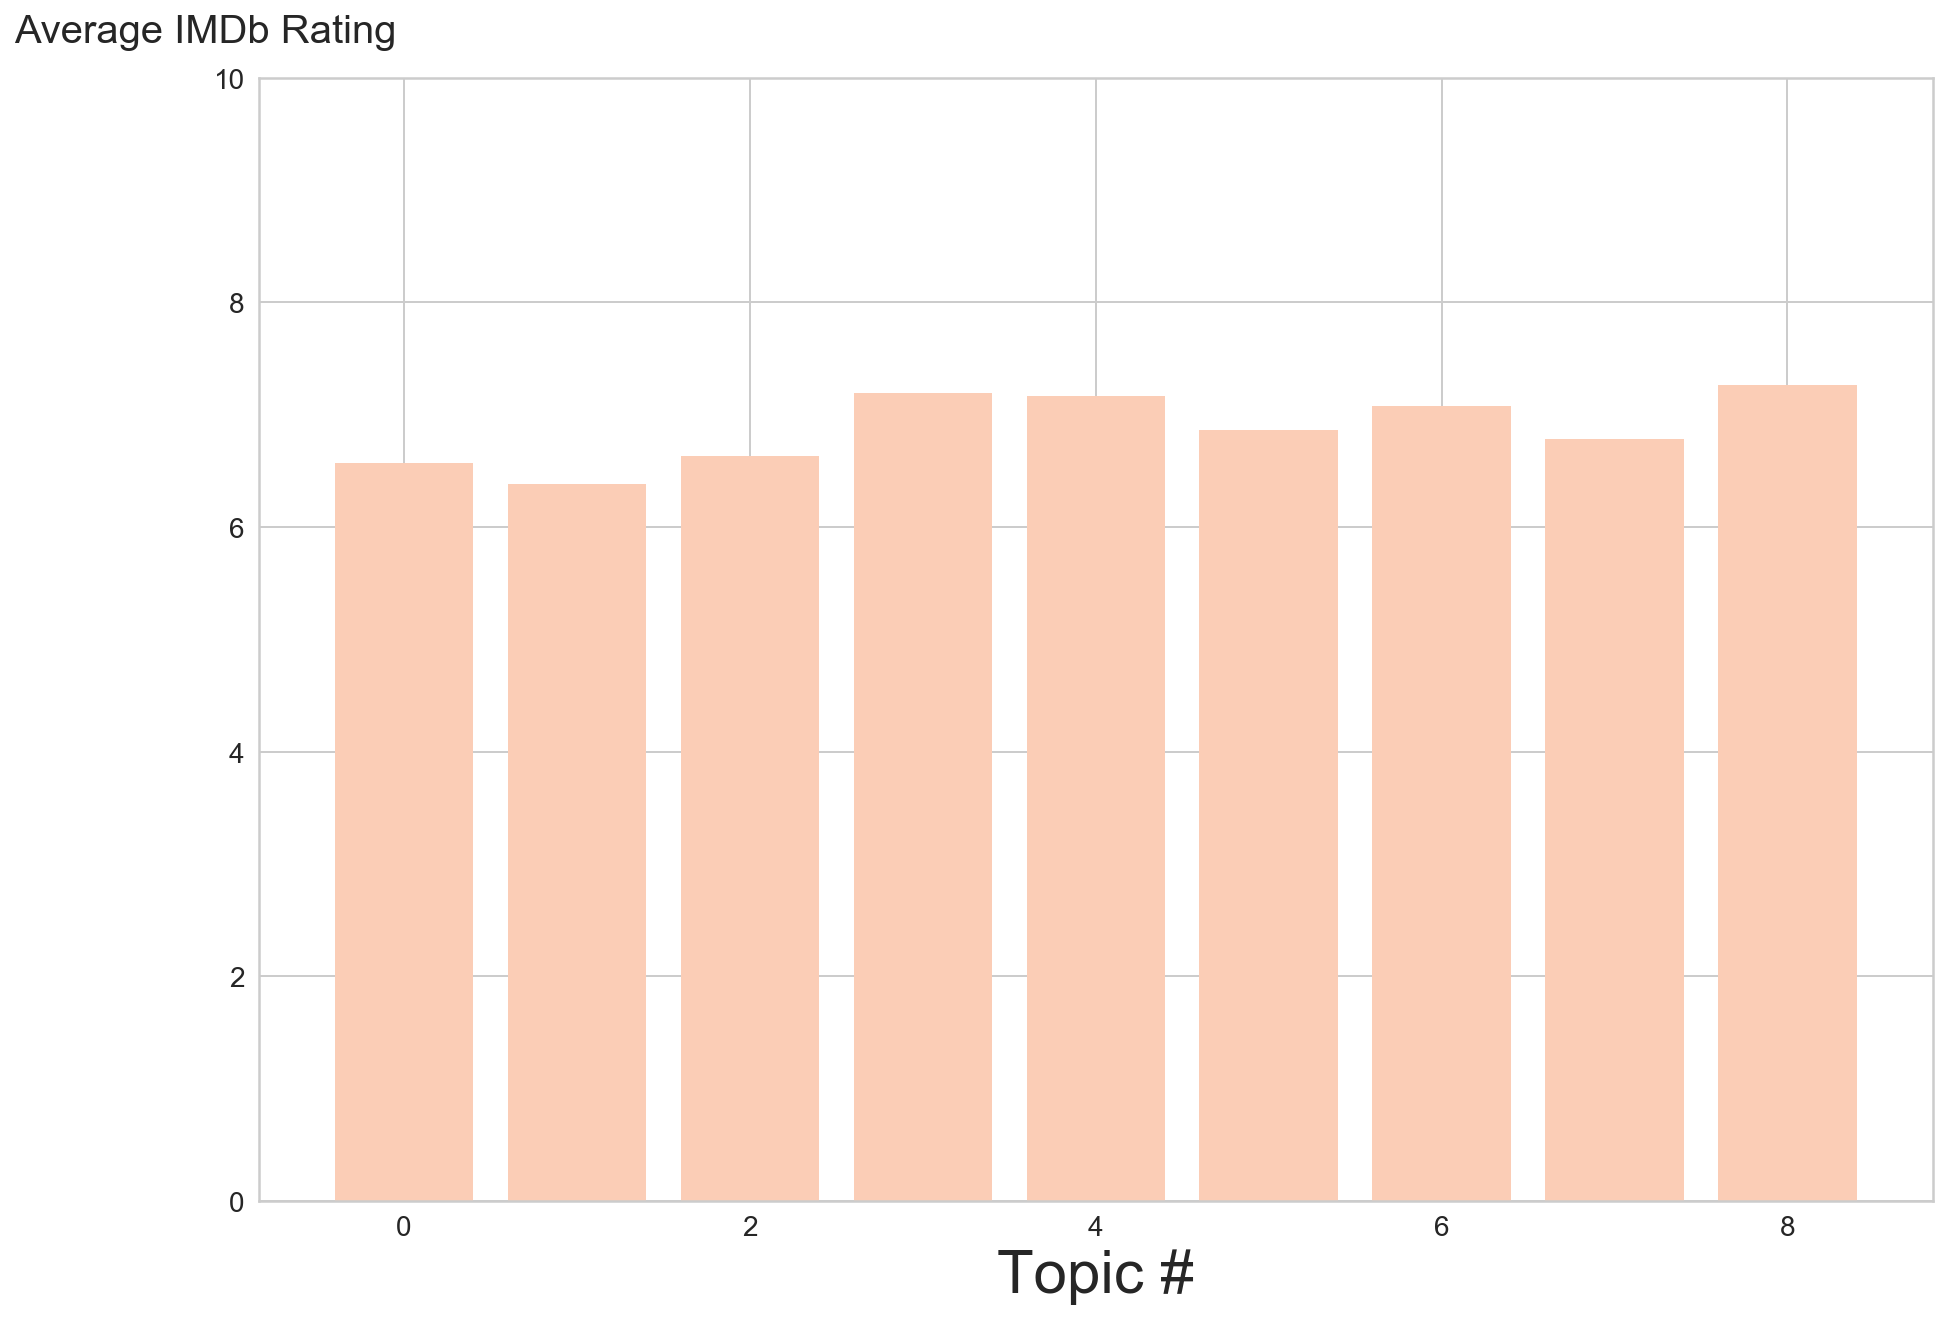

In [82]:
plt.figure(figsize=(15, 10))
topic_num = [x[0] for x in topic_rating]
ratings = [x[1] for x in topic_rating]


plt.bar(topic_num, ratings, color=['#fbcdb6', '#fbcdb6', '#fbcdb6', '#fbcdb6', '#fbcdb6', 
                                   '#fbcdb6', '#fbcdb6', '#fbcdb6', '#fbcdb6']
                                   )
# plt.title('IMDb Rating vs. Topic #', size=30, y=1.05)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim(0,10)
plt.ylabel('Average IMDb Rating', size=20, rotation=0, position=(0,1.025))
plt.xlabel('Topic #', size=30)
# plt.xticks(rotation=45, ha='right', visible=False)
plt.savefig(f'visualizations/imbdrating_topic_fixed_scale.png', transparent=True, bbox_inches = 'tight' )

In [83]:
topic_dict = dict(Counter(best_topic_nmf_chosen))

In [84]:
topic_dict

{0: 117, 5: 81, 2: 93, 7: 40, 4: 53, 3: 104, 1: 39, 6: 48, 8: 42}

In [85]:
temp_df = pd.DataFrame(topic_dict.items(), columns=['nmf_topic', 'count'])

In [86]:
temp_df

,nmf_topic,count
0,0,117
1,5,81
2,2,93
3,7,40
4,4,53
5,3,104
6,1,39
7,6,48
8,8,42


In [87]:
topic_mean

,year,IMDBrating,numIMDBvotes
nmf_topic,,,
8,1983.000000,7.264286,64159.880952
3,1979.951923,7.195192,44703.173077
4,1984.792453,7.169811,41021.867925
6,1996.354167,7.079167,61335.354167
5,1985.246914,6.866667,51795.518519
7,1987.525000,6.780000,46211.175000
2,1994.946237,6.633333,58183.806452
0,1993.547009,6.567521,41773.358974
1,1991.025641,6.387179,49614.666667


In [88]:
topic_mean_count = topic_mean.merge(temp_df, left_on='nmf_topic', right_on='nmf_topic', how='outer')

In [89]:
topic_mean_count

,nmf_topic,year,IMDBrating,numIMDBvotes,count
0,8,1983.000000,7.264286,64159.880952,42
1,3,1979.951923,7.195192,44703.173077,104
2,4,1984.792453,7.169811,41021.867925,53
3,6,1996.354167,7.079167,61335.354167,48
4,5,1985.246914,6.866667,51795.518519,81
5,7,1987.525000,6.780000,46211.175000,40
6,2,1994.946237,6.633333,58183.806452,93
7,0,1993.547009,6.567521,41773.358974,117
8,1,1991.025641,6.387179,49614.666667,39


## LDA

In [90]:
def performLDAgensim(vectorizer, n_range, stop, max_docfreq, file_mod = ''):
    '''
    Arguments:
    vectorizer -- 'cv' or 'tfidf'
    n_range -- '(1, 1)', '(1, 2)', or '(2, 2)'
    stop -- 'english', 'noman' or 'man'
    max_docfreq -- 0.8, 1.0 (depends)
    file_mod -- allows for rating file access: '_bad', '_neutral', or '_good'
    '''
    with open(f'cv/{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'rb') as handle:
        vec = pickle.load(handle)
    dtm = pd.read_pickle(f'dtm/dtm_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl')
    
    print(f'Gensim LDA using {vectorizer}, with n_gram of {n_range}, stop words of {stop}, and max_df of {max_docfreq}')
    tdm = dtm.transpose()
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())

    lda = models.LdaModel(corpus=corpus, id2word=id2word,
                           num_topics=num_features, passes=20)
    
    with open(f'models/lda_{vectorizer}{file_mod}_{n_range}_{stop}_{max_docfreq}.pkl', 'wb') as handle:
        pickle.dump(lda, handle)
        
#     coherence_model_lda = CoherenceModel(model=lda, coherence='c_v')

#     print(f'The coherence score is: {coherence_model_lda.get_coherence()}')
    print('---')
    print('The topics are:')
    print(lda.print_topics())

In [91]:
# from gensim.models import CoherenceModel

# tdm1 = data_dtm_1.transpose()
# sparse_counts1 = scipy.sparse.csr_matrix(tdm1)
# corpus1 = matutils.Sparse2Corpus(sparse_counts1)
# id2word1 = dict((v, k) for k, v in cv1.vocabulary_.items())

# for x in range(1,20):
#     lda1 = models.LdaModel(corpus=corpus1, id2word=id2word1,
#                            num_topics=x, passes=100)
#     lda1.print_topics()

#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(lda1, corpus1, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print(f'\nCoherence Score for {x} topics is', coherence_lda)

In [92]:
# tdm1 = data_dtm_1.transpose()
# sparse_counts1 = scipy.sparse.csr_matrix(tdm1)
# corpus1 = matutils.Sparse2Corpus(sparse_counts1)
# id2word1 = dict((v, k) for k, v in cv1.vocabulary_.items())

# lda1 = models.LdaModel(corpus=corpus1, id2word=id2word1,
#                        num_topics=20, passes=20)
# lda1.print_topics()

In [93]:
# tdm1

In [94]:
# corpus_transformed1 = lda1[corpus1]
# graph1 = list(zip([max(a)[0] for a in corpus_transformed1], data_dtm_1.index))
# graph1

### gensim | CV | Unigram | Custom Manual Stop Words | 0.85

In [95]:
# performLDAgensim(vectorizer = 'cv', n_range = '(1, 1)', stop = 'man', max_docfreq = '0.85')

### gensim | CV | Bigram | Custom Manual Stop Words | 0.85

In [96]:
# performLDAgensim(vectorizer = 'cv', n_range = '(2, 2)', stop = 'man', max_docfreq = '0.85')

### pyLDAvis - sklearn | CV | Unigram |  Standard Stop Words | 0.8

In [97]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=3,
#                              max_df=0.8,
#                              stop_words='english',
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
# lda_model = LatentDirichletAllocation(n_components=num_features,  # Number of topics
#                                       learning_method='online',
#                                       random_state=0,
#                                       n_jobs=-1  # Use all available CPUs
#                                       )
# lda_output = lda_model.fit_transform(data_vectorized)

# display_topics(lda_model, vectorizer.get_feature_names(), 40)

# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

### pyLDAvis - sklearn | CV | Bigram |  Standard Stop Words | 0.8

In [98]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=3,
#                              max_df=0.8,
#                              stop_words='english',
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              ngram_range = (2,2)
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
# lda_model = LatentDirichletAllocation(n_components=num_features,  # Number of topics
#                                       learning_method='online',
#                                       random_state=0,
#                                       n_jobs=-1  # Use all available CPUs
#                                       )

# lda_output = lda_model.fit_transform(data_vectorized)

# display_topics(lda_model, vectorizer.get_feature_names(), 20)

# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

### pyLDAvis - sklearn | CV | Bigram | Custom Manual Stop Words | 0.8

In [99]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=3,
#                              max_df=0.8,
#                              stop_words=manstop,
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              ngram_range = (2,2)
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
# lda_model = LatentDirichletAllocation(n_components=num_features,  # Number of topics
#                                       learning_method='online',
#                                       random_state=0,
#                                       n_jobs=-1  # Use all available CPUs
#                                       )

# lda_output = lda_model.fit_transform(data_vectorized)

# display_topics(lda_model, vectorizer.get_feature_names(), 40)

# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

### pyLDAvis - sklearn | TF-IDF | Unigram | Custom Manual Stop Words | 0.85

In [100]:
vectorizer = TfidfVectorizer(analyzer='word',
                             min_df=3,
                             max_df=0.85,
                             stop_words=manstop,
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000,
                             ngram_range = (1,1)
                             )

data_vectorized = vectorizer.fit_transform(data_df['script'])
lda_model = LatentDirichletAllocation(n_components=9,  # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs=-1  # Use all available CPUs
                                      )

lda_output = lda_model.fit_transform(data_vectorized)

display_topics(lda_model, vectorizer.get_feature_names(), 40)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')


Topic  0
fuck, shit, game, money, kill, fucking, girl, house, excellency, movie, fuckin, killed, someone, kid, year, course, father, forgive, real, listen, minute, car, country, already, war, great, cigar, pre, idea, power, saying, play, home, many, husband, word, mon, asshole, dead, part

Topic  1
money, film, girl, shark, dollar, pudding, hello, big, home, house, mister, nice, car, country, guess, cop, care, hundred, boy, ask, bos, went, hospital, fuck, talking, called, walk, remember, stuff, mile, thousand, wife, minute, game, story, year, course, check, kill, business

Topic  2
sir, ship, egg, hello, needed, corporate, plane, hand, baby, million, side, ask, year, fucking, passenger, fuck, area, colony, duty, bloody, instruction, warrior, congratulation, island, might, team, lead, understand, record, leak, destroying, celebration, gold, east, york, knowu, looking, walk, bit, suck

Topic  3
ship, father, computer, killed, might, stop, dream, steed, child, baby, run, best, kid, girl,

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      111.092506 -133.722946       1        1  95.293124
5       34.946613  107.064590       2        1   0.588360
1      -28.088213 -159.949036       3        1   0.588360
8      147.698074   21.369604       4        1   0.588360
0      -97.501183  126.981384       5        1   0.588360
3       30.312096  -32.794945       6        1   0.588360
6     -155.443665 -118.494690       7        1   0.588360
2     -204.248108   22.596130       8        1   0.588360
7      -79.404678   -6.864717       9        1   0.588360, topic_info=         Term       Freq      Total Category  logprob  loglift
3960     shit  21.000000  21.000000  Default  30.0000  30.0000
4027      sir  25.000000  25.000000  Default  29.0000  29.0000
2810    money  21.000000  21.000000  Default  28.0000  28.0000
1835     fuck  19.000000  19.000000  Default  27.0000  27.0000
1900     girl  18.000000  18.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1839  fucking   0.013218  18.967312   Topic9  -8.4962  -2.1333
3828   school   0.013218  12.030470   Topic9  -8.4962  -1.6781
563       bug   0.013217   2.711165   Topic9  -8.4963  -0.1880
2483    later   0.013216   7.579159   Topic9  -8.4963  -1.2161
4387    swear   0.013213   4.865580   Topic9  -8.4966  -0.7731

[846 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        1  1.584461       accessory
19        1  1.504560       accompany
52        1  1.391729          adjust
54        1  1.244198  administration
55        1  1.020781         admiral
...     ...       ...             ...
4925      1  1.019418            wish
4933      1  0.979163           woman
4946      1  0.995890           world
4974      1  1.178376             yah
4976      1  1.019834            year

[449 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 9, 1, 4, 7, 3, 8])

The following two sections (Nouns and Nouns and Adjectives) were based off of instructions from Alice Zhao.  
I didn't end up using either methods.  
https://github.com/adashofdata/nlp-in-python-tutorial

### Nouns Only

In [101]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    def is_noun(pos): return pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [102]:
# Apply the nouns function to the transcripts to filter only on nouns
# data_nouns = pd.DataFrame(data_df.script.apply(nouns))

In [103]:
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [104]:
# data_nouns.to_pickle("dataframes/data_nouns.pkl")
data_nouns = pd.read_pickle("dataframes/data_nouns.pkl")

In [105]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
# cvn = CountVectorizer(stop_words=stop_words)

cvn = CountVectorizer(ngram_range=(1, 1), stop_words=manstop, max_df = 0.80)
data_cvn = cvn.fit_transform(data_nouns.script)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
# data_dtmn

In [106]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(
    scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [107]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=num_features,
                       id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.007*"world" + 0.006*"money" + 0.006*"baby" + 0.005*"boy" + 0.004*"woman" + 0.004*"mother" + 0.004*"problem" + 0.004*"school" + 0.004*"someone" + 0.004*"car"'),
 (1,
  '0.006*"sir" + 0.005*"woman" + 0.005*"boy" + 0.005*"men" + 0.004*"world" + 0.004*"night" + 0.004*"word" + 0.004*"someone" + 0.004*"room" + 0.004*"business"'),
 (2,
  '0.008*"woman" + 0.006*"home" + 0.006*"mother" + 0.006*"money" + 0.005*"house" + 0.005*"girl" + 0.005*"father" + 0.005*"please" + 0.005*"minute" + 0.005*"wife"'),
 (3,
  '0.013*"money" + 0.008*"girl" + 0.008*"car" + 0.007*"house" + 0.006*"shit" + 0.006*"home" + 0.006*"kid" + 0.006*"guess" + 0.006*"night" + 0.006*"fuck"'),
 (4,
  '0.010*"money" + 0.006*"car" + 0.005*"night" + 0.005*"yah" + 0.004*"tape" + 0.004*"idea" + 0.004*"wife" + 0.003*"deal" + 0.003*"dollar" + 0.003*"someone"'),
 (5,
  '0.013*"father" + 0.008*"girl" + 0.006*"someone" + 0.005*"family" + 0.005*"home" + 0.005*"child" + 0.005*"god" + 0.005*"mother" + 0.005*"woman" + 0.005*"world"'),

In [108]:
vectorizern = CountVectorizer(analyzer='word',
                              min_df=3,
                              max_df=0.8,
                              stop_words=manstop,
                              lowercase=True,
                              token_pattern='[a-zA-Z0-9]{3,}',
                              )

data_vectorizedn = vectorizern.fit_transform(data_nouns['script'])

lda_modeln = LatentDirichletAllocation(n_components=num_features,  # Number of topics
                                       learning_method='online',
                                       random_state=0,
                                       n_jobs=-1  # Use all available CPUs
                                       )
lda_outputn = lda_modeln.fit_transform(data_vectorizedn)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_modeln, data_vectorizedn, vectorizern, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      111.092506 -133.722946       1        1  36.566089
5       34.946613  107.064590       2        1  34.286357
7      -28.088213 -159.949036       3        1  20.933215
2      147.698074   21.369604       4        1   6.137159
8      -97.501183  126.981384       5        1   1.939307
3       30.312096  -32.794945       6        1   0.080952
1     -155.443665 -118.494690       7        1   0.018974
0     -204.248108   22.596130       8        1   0.018974
4      -79.404678   -6.864717       9        1   0.018974, topic_info=          Term         Freq        Total Category  logprob  loglift
6406       sir  1417.000000  1417.000000  Default  30.0000  30.0000
6306      ship   555.000000   555.000000  Default  29.0000  29.0000
4578     money  2808.000000  2808.000000  Default  28.0000  28.0000
791        boy  1638.000000  1638.000000  Default  27.0000  27.0000
5390     power   639.000000   639.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
4578     money     0.014794  2808.411767   Topic9  -8.4384  -3.5840
4507    minute     0.014255  1733.723075   Topic9  -8.4755  -3.1388
5036      part     0.013873  1115.874216   Topic9  -8.5027  -2.7253
1040       car     0.014054  1770.078552   Topic9  -8.4897  -3.1737
5635  question     0.013838  1137.631763   Topic9  -8.5051  -2.7471

[720 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
18        1  0.155388  access
18        2  0.038847  access
18        3  0.767229  access
18        5  0.038847  access
44        1  0.854430   actor
...     ...       ...     ...
7902      4  0.078014    york
7902      5  0.002167    york
7919      1  0.941319  yuppie
7929      3  0.636004    zoom
7929      4  0.318002    zoom

[1334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 3, 9, 4, 2, 1, 5])

### Nouns and Adjectives

In [109]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    def is_noun_adj(pos): return pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(
        tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [110]:
# Apply the nouns function to the transcripts to filter only on nouns
# data_nouns_adj = pd.DataFrame(data_df.script.apply(nouns_adj))

In [111]:
# data_nouns_adj.to_pickle("dataframes/data_nouns_adj.pkl")
data_nouns_adj = pd.read_pickle("dataframes/data_nouns_adj.pkl")

In [112]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
# cvna = CountVectorizer(stop_words=stop_words, max_df=.8)

cvna = CountVectorizer(ngram_range=(1, 1), stop_words=manstop, max_df = 0.80)
data_cvna = cvna.fit_transform(data_nouns_adj.script)
data_dtmna = pd.DataFrame(
    data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
# data_dtmna

In [113]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(
    scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [114]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=num_features,
                        id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.010*"sir" + 0.007*"ship" + 0.005*"father" + 0.004*"world" + 0.004*"power" + 0.004*"dr" + 0.004*"god" + 0.004*"doctor" + 0.004*"someone" + 0.003*"hour"'),
 (1,
  '0.008*"money" + 0.004*"problem" + 0.004*"shit" + 0.004*"car" + 0.003*"business" + 0.003*"night" + 0.003*"kid" + 0.003*"dollar" + 0.003*"someone" + 0.003*"nice"'),
 (2,
  '0.008*"yah" + 0.005*"night" + 0.004*"world" + 0.003*"deal" + 0.003*"school" + 0.003*"special" + 0.003*"class" + 0.003*"god" + 0.002*"someone" + 0.002*"thanks"'),
 (3,
  '0.011*"money" + 0.008*"shit" + 0.007*"fuck" + 0.005*"movie" + 0.005*"cop" + 0.005*"girl" + 0.005*"woman" + 0.005*"car" + 0.004*"fucking" + 0.004*"gun"'),
 (4,
  '0.006*"sir" + 0.005*"men" + 0.004*"room" + 0.004*"general" + 0.004*"war" + 0.003*"boy" + 0.003*"please" + 0.003*"world" + 0.003*"many" + 0.003*"whole"'),
 (5,
  '0.006*"doctor" + 0.004*"world" + 0.004*"dr" + 0.004*"sir" + 0.003*"body" + 0.003*"head" + 0.003*"woman" + 0.003*"mother" + 0.003*"girl" + 0.003*"question"'),
 (6,


In [115]:
corpus_transformed_na = ldana[corpusna]
graph_na = list(zip([max(a)[0]
                     for a in corpus_transformed_na], data_dtmna.index))
graph_na

[(8, 0),
 (0, 1),
 (8, 2),
 (0, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 8),
 (0, 9),
 (8, 10),
 (7, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 (8, 15),
 (8, 16),
 (8, 17),
 (8, 18),
 (8, 19),
 (8, 20),
 (8, 21),
 (8, 22),
 (8, 23),
 (8, 24),
 (8, 25),
 (3, 26),
 (8, 27),
 (6, 28),
 (3, 29),
 (8, 30),
 (8, 31),
 (8, 32),
 (8, 33),
 (8, 34),
 (8, 35),
 (8, 36),
 (8, 37),
 (8, 38),
 (8, 39),
 (6, 40),
 (8, 41),
 (8, 42),
 (1, 43),
 (8, 44),
 (8, 45),
 (8, 46),
 (4, 47),
 (8, 48),
 (8, 49),
 (8, 50),
 (8, 51),
 (8, 52),
 (6, 53),
 (8, 54),
 (8, 55),
 (8, 56),
 (0, 57),
 (5, 58),
 (8, 59),
 (8, 60),
 (8, 61),
 (8, 62),
 (8, 63),
 (8, 64),
 (8, 65),
 (8, 66),
 (8, 67),
 (5, 68),
 (4, 69),
 (8, 70),
 (7, 71),
 (8, 72),
 (8, 73),
 (8, 74),
 (8, 75),
 (8, 76),
 (8, 77),
 (8, 78),
 (8, 79),
 (8, 80),
 (8, 81),
 (8, 82),
 (8, 83),
 (8, 84),
 (8, 85),
 (8, 86),
 (8, 87),
 (8, 88),
 (8, 89),
 (8, 90),
 (8, 91),
 (8, 92),
 (8, 93),
 (8, 94),
 (8, 95),
 (8, 96),
 (8, 97),
 (8, 98),
 (8, 99),
 (8, 100),

In [116]:
vectorizerna = CountVectorizer(analyzer='word',
                               min_df=3,
                               max_df=0.8,
                               stop_words=manstop,
                               lowercase=True,
                               token_pattern='[a-zA-Z0-9]{3,}',
                               )

data_vectorizedna = vectorizerna.fit_transform(data_nouns_adj['script'])

lda_modelna = LatentDirichletAllocation(n_components=num_features,  # Number of topics
                                        learning_method='online',
                                        random_state=0,
                                        n_jobs=-1  # Use all available CPUs
                                        )
lda_outputna = lda_modelna.fit_transform(data_vectorizedna)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_modelna, data_vectorizedna,
                         vectorizerna, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      111.092506 -133.722946       1        1  78.640685
7       34.946613  107.064590       2        1  12.542983
0      -28.088213 -159.949036       3        1   8.460429
4      147.698074   21.369604       4        1   0.211621
8      -97.501183  126.981384       5        1   0.044652
6       30.312096  -32.794945       6        1   0.042488
3     -155.443665 -118.494690       7        1   0.028125
5     -204.248108   22.596130       8        1   0.014508
2      -79.404678   -6.864717       9        1   0.014508, topic_info=           Term         Freq        Total Category  logprob  loglift
4394        huh  1140.000000  1140.000000  Default  30.0000  30.0000
4116       head  1321.000000  1321.000000  Default  29.0000  29.0000
5807      money  2724.000000  2724.000000  Default  28.0000  28.0000
4972        kid  1543.000000  1543.000000  Default  27.0000  27.0000
8180        sir  1982.000000  1982.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
8673      story     0.013141  1096.176516   Topic9  -8.5575  -2.4934
5549     matter     0.013433  1356.906475   Topic9  -8.5355  -2.6848
696   beautiful     0.012636   813.540284   Topic9  -8.5967  -2.2344
8731      stuff     0.012896  1027.300794   Topic9  -8.5764  -2.4473
8055       shit     0.013389  1724.146056   Topic9  -8.5388  -2.9276

[617 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
28         1  0.330136      access
28         3  0.669443      access
36         1  0.194211  accordance
36         2  0.194211  accordance
36         3  0.388422  accordance
...      ...       ...         ...
10218      4  0.001260       young
10247      1  0.876878         zoo
10247      2  0.037314         zoo
10247      3  0.037314         zoo
10247      4  0.037314         zoo

[925 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 5, 9, 7, 4, 6, 3])

# Separating Movies by Rating

In [117]:
# movie_titles_metadata

In [118]:
movie_titles_metadata['IMDBrating'].value_counts(bins=2)

(5.9, 9.3]      490
(2.492, 5.9]    127
Name: IMDBrating, dtype: int64

In [119]:
# movie_titles_metadata['IMDBrating'].value_counts(bins=9)

# 166 - (2.492,6.278]
# 288 - (6.278,7.789]
# 163 - (7.789,9.3]
       
# (7.033, 7.789]    144
# (6.278, 7.033]    144
# (7.789, 8.544]    138
# (5.522, 6.278]     82
# (4.767, 5.522]     44
# (8.544, 9.3]       25
# (4.011, 4.767]     24
# (3.256, 4.011]     12
# (2.492, 3.256]      4

In [120]:
list_up = list(
    movie_titles_metadata[movie_titles_metadata['IMDBrating'] >= 6]['movieID'])

list_down = list(
    movie_titles_metadata[movie_titles_metadata['IMDBrating'] < 6]['movieID'])

In [121]:
list_up = [int(x.replace('m', '')) for x in list_up]
list_down = [int(x.replace('m', '')) for x in list_down]

In [122]:
print(f'The number of movies with a bad rating is {len(list_down)}')
print(f'The number of movies with a good rating is {len(list_up)}')

The number of movies with a bad rating is 127
The number of movies with a good rating is 490


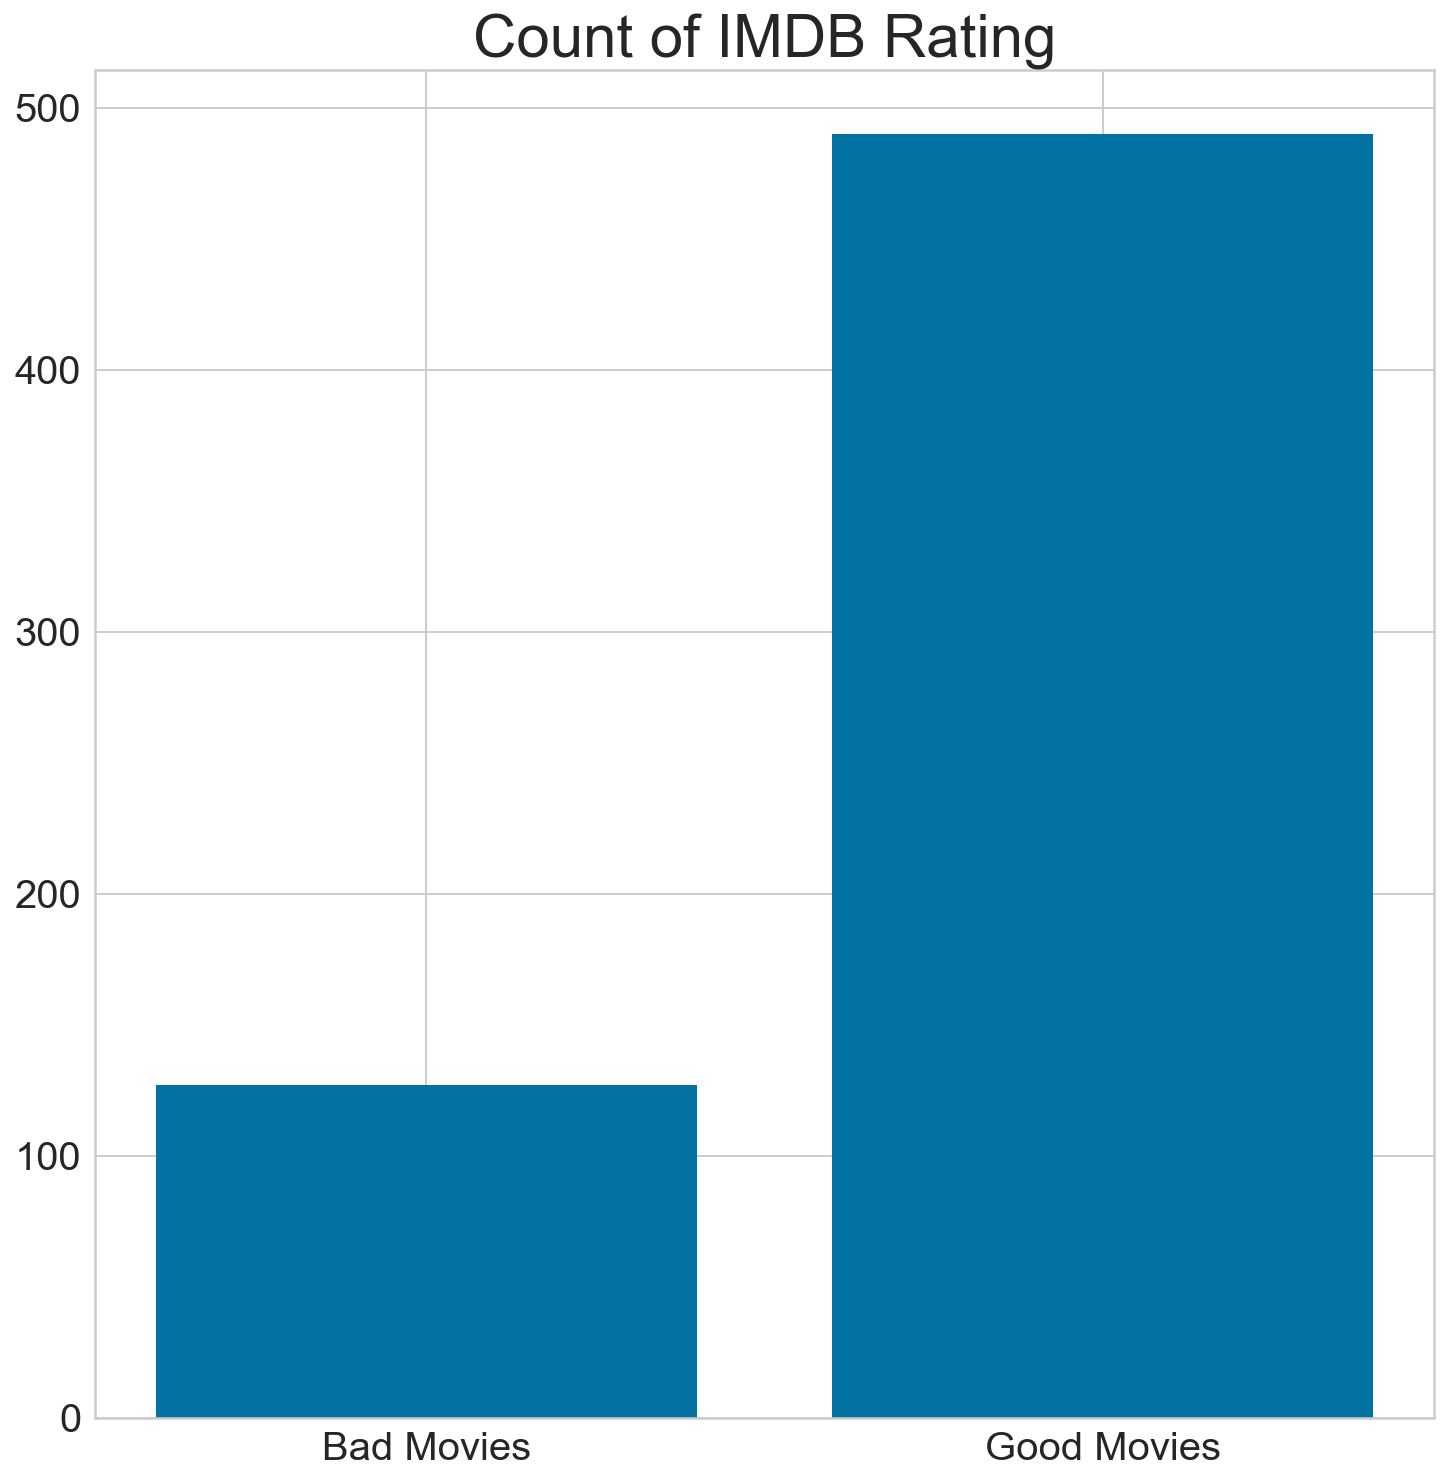

In [123]:
rating_labels = ['Bad Movies', 'Good Movies']
rating_counts = [len(list_down), len(list_up)]
plt.bar(rating_labels, rating_counts)
plt.title('Count of IMDB Rating', size = 30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig(f'visualizations/imdb_rating_count.png', transparent=True, bbox_inches = 'tight' )

In [124]:
df_down= data_df.loc[list_down].copy()
df_up = data_df.loc[list_up].copy()

In [125]:
df_down.to_pickle("dataframes/df_down.pkl")
df_up.to_pickle("dataframes/df_up.pkl")

## NMF

In [126]:
# performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'noman', max_docfreq = '0.9', file_mod = '_bad')

In [127]:
# performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'noman', max_docfreq = '0.9', file_mod = '_neutral')

In [128]:
# performNMF(vectorizer = 'cv', n_range = '(1, 1)', stop = 'noman', max_docfreq = '0.9', file_mod = '_good')

The mean of individual topic weights over all documents is:
[0.04728268 0.0189855  0.04591676 0.03084221 0.05120662 0.04223714
 0.03161595 0.03237594 0.03505619]
---
The variance of individual topic weights over all documents is:
[0.00293097 0.002697   0.00384222 0.00388973 0.00400869 0.00405233
 0.00294397 0.00359051 0.00327854]
---
The topics are:

Topic  0
school, great, year, home, mom, kid, guess, nice, house, thanks, big, fine, huh, god, baby, girl, mother, married, movie, stuff, night, dad, actually, date, wanted, show, pretty, party, parent, someone, hello, father, um, talking, woman, real, sex, dinner, book, listen, together, class, wow, play, week, anyway, trying, getting, called, minute, start, thank, person, thinking, hate, live, every, ask, went, alright

Topic  1
ship, admiral, enterprise, commander, sir, planet, system, power, crew, warp, shield, command, space, data, torpedo, signal, computer, beam, control, unit, radiation, mission, aboard, scan, vessel, weapon, whale,

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

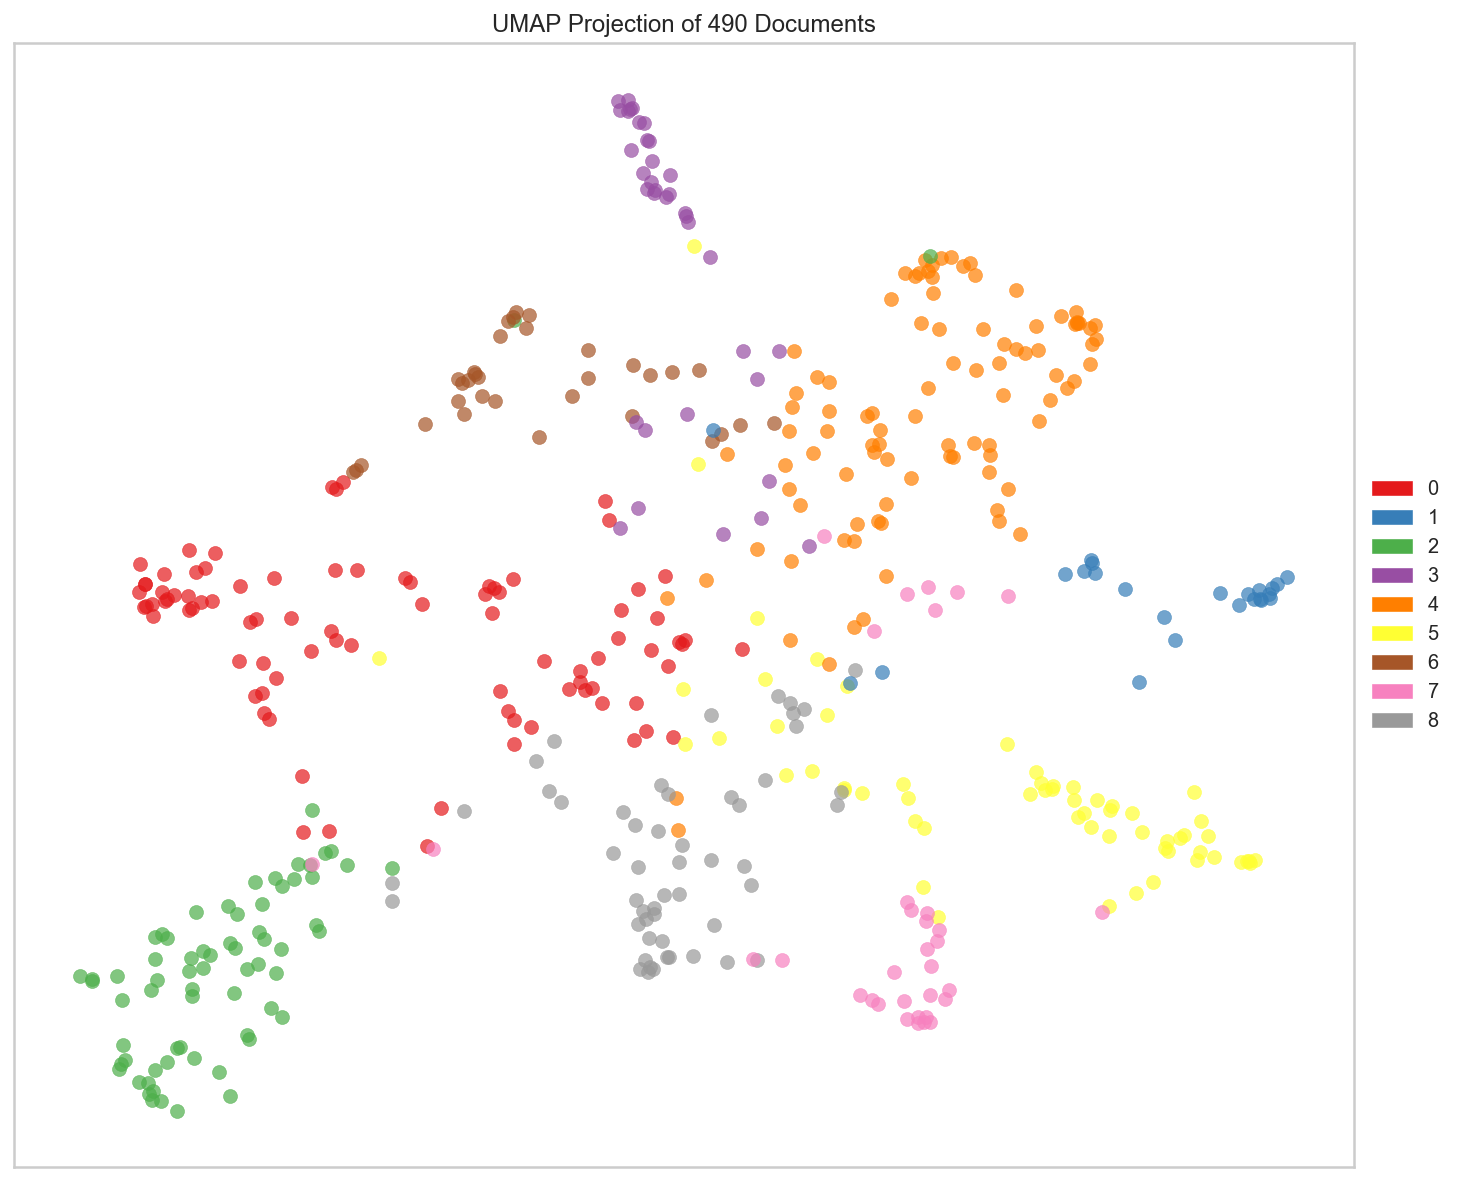

In [129]:
tf, dtm = createCustomTFIDFvectorizer(df_up, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.85)

index_names = [f'component_{x}' for x in range(9)]
doc_topic_nmf_selection = performCustomNMF(tf, dtm, num_features = 9, index_names = index_names)

The mean of individual topic weights over all documents is:
[0.05373424 0.06090869 0.02850712 0.022804   0.02408855 0.05020015
 0.06659044 0.07078624 0.03563618]
---
The variance of individual topic weights over all documents is:
[0.00649333 0.00853055 0.00757205 0.01209764 0.00827996 0.01075147
 0.01139524 0.01205625 0.01061529]
---
The topics are:

Topic  0
shit, fuck, fucking, money, int, car, kill, truck, damn, brother, fuckin, gun, cop, business, dollar, girl, kid, boy, shut, crazy, real, black, killed, alright, name, big, goddamn, fucked, witch, talking, hit, stay, judge, bastard, thousand, nobody, shoot, panther, lot, house, baby, friend, hostage, everybody, guess, night, bitch, asshole, hand, told, walk, show, hear, cause, head, stupid, security, enough, inside, dog

Topic  1
sir, dr, must, war, thank, men, made, course, year, doctor, perhaps, power, colonel, quite, might, train, world, woman, general, lieutenant, plane, name, steed, dear, creature, mind, bank, ah, majesty, tre

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

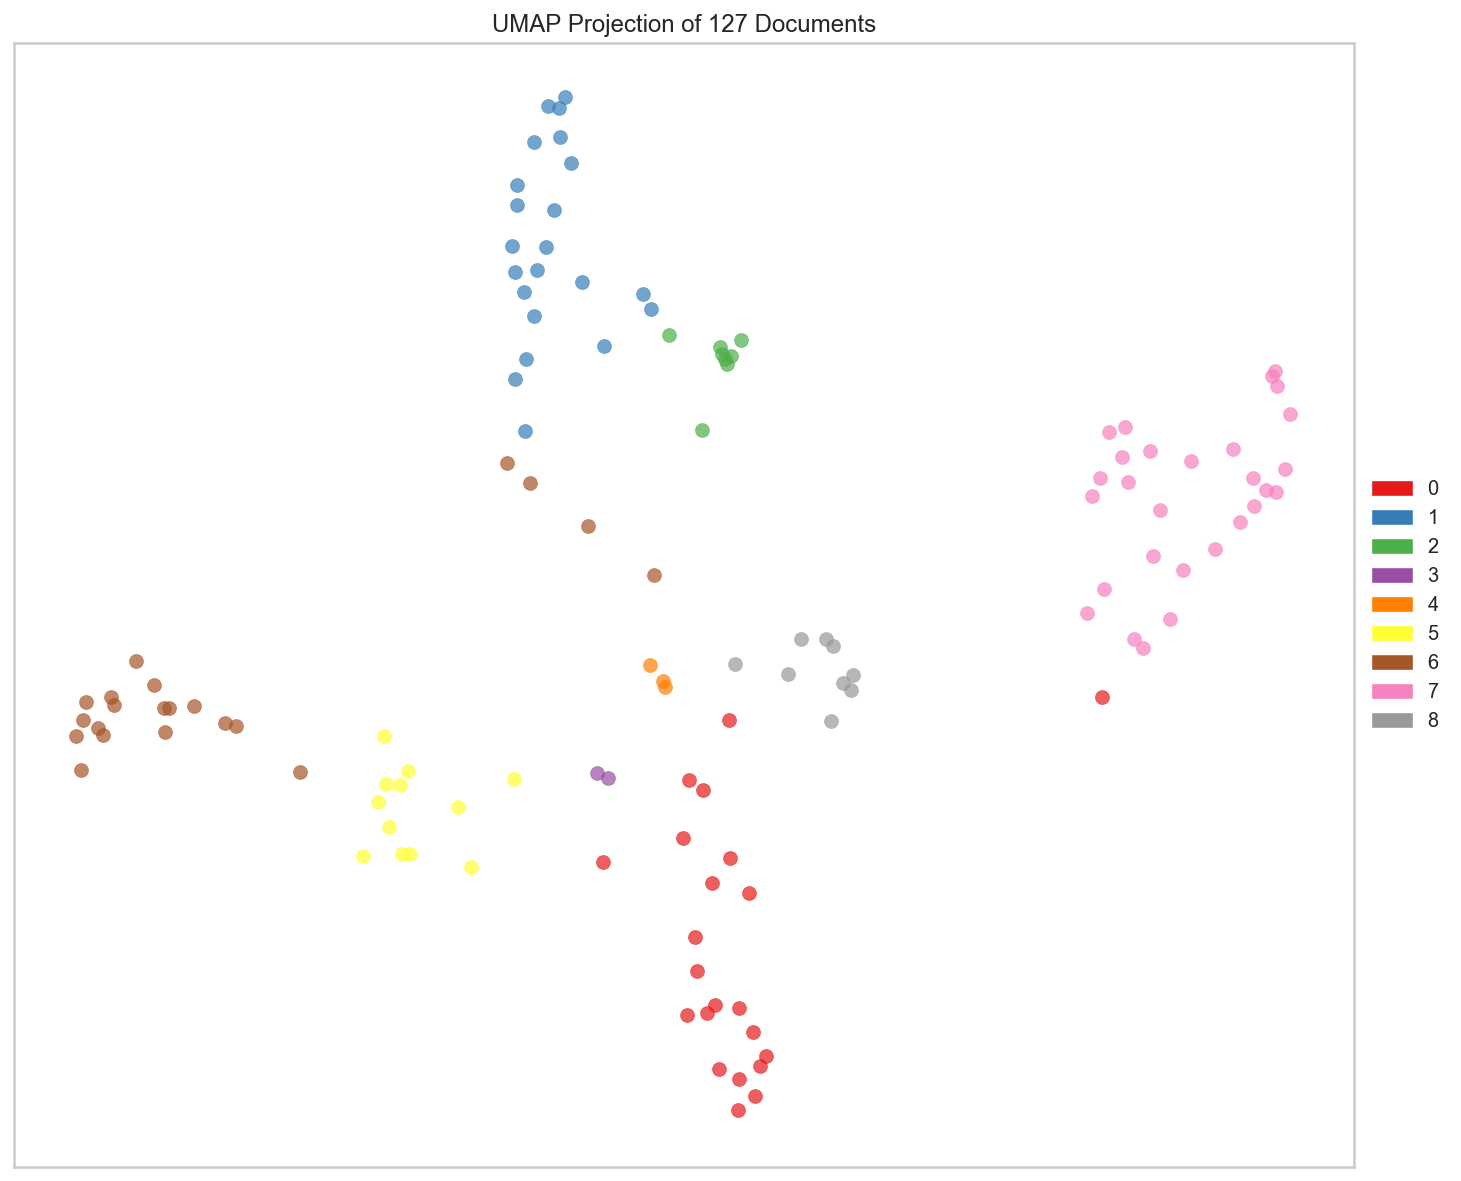

In [130]:
tf, dtm = createCustomTFIDFvectorizer(df_down, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.85)

index_names = [f'component_{x}' for x in range(9)]
doc_topic_nmf_selection = performCustomNMF(tf, dtm, num_features = 9, index_names = index_names)

# Sample Movies to Check Topics Against (Movies I've Watched)

In [131]:
# m117 +++$+++ legally blonde +++$+++ 2001 +++$+++ 6.20 +++$+++ 44558 +++$+++ ['comedy']
# m240 +++$+++ american pie +++$+++ 1999 +++$+++ 6.90 +++$+++ 107961 +++$+++ ['comedy', 'romance']
# m253 +++$+++ back to the future +++$+++ 1985 +++$+++ 8.40 +++$+++ 207376 +++$+++ ['adventure', 'family', 'sci-fi']
# m529 +++$+++ star wars +++$+++ 1977 +++$+++ 8.80 +++$+++ 326619 +++$+++ ['action', 'adventure', 'fantasy', 'sci-fi']
# m574 +++$+++ titanic +++$+++ 1997 +++$+++ 7.40 +++$+++ 244771 +++$+++ ['drama', 'history', 'romance']
# m579 +++$+++ toy story +++$+++ 1995 +++$+++ 8.20 +++$+++ 156231 +++$+++ ['animation', 'adventure', 'comedy', 'family', 'fantasy']
# m602 +++$+++ what women want +++$+++ 2000 +++$+++ 6.30 +++$+++ 55269 +++$+++ ['comedy', 'fantasy', 'romance']

In [132]:
movie_selection = [240, 253, 117, 529, 574, 579, 602]

# Sentiment Analysis

In [133]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer() 

In [134]:
# sentiment for toy story
sentiment_dict = sid_obj.polarity_scores(data_df.iloc[579]['script']) 
sentiment_dict['compound']

0.9969

In [135]:
for x in movie_selection:
    title = movie_titles_metadata.iloc[x]['title']
    sentiment = sid_obj.polarity_scores(data_df.iloc[x]['script'])['compound']
    print(f'the sentiment for {title} is {sentiment}')

the sentiment for american pie is 1.0
the sentiment for back to the future is 0.9998
the sentiment for legally blonde is 0.9999
the sentiment for star wars is -0.7318
the sentiment for titanic is 0.9999
the sentiment for toy story is 0.9969
the sentiment for what women want is -0.6705


# Visualizations

In [136]:
docnames = []
for x in movie_selection:
    docnames.append(string.capwords(movie_titles_metadata.iloc[x]['title']))
docnames

['American Pie',
 'Back To The Future',
 'Legally Blonde',
 'Star Wars',
 'Titanic',
 'Toy Story',
 'What Women Want']

In [137]:
doctopics = []
for x in movie_selection:
    doctopics.extend([doc_topic_nmf_chosen[x]])

doctopics = np.array(doctopics)

In [138]:
doctopics_divided = []
for x in doctopics:
    print(x)
    doctopics_divided.extend([np.divide(x,sum(x))])

[0.16634193 0.00337522 0.         0.         0.         0.
 0.05458425 0.         0.00688369]
[0.10667659 0.05376697 0.02775769 0.         0.         0.00650152
 0.         0.00835296 0.01801955]
[0.12533169 0.         0.0360408  0.00928876 0.         0.00922209
 0.         0.03311712 0.01161442]
[0.         0.1830319  0.02395161 0.         0.         0.07996513
 0.         0.         0.10795143]
[0.02132567 0.13630743 0.         0.08404461 0.06761446 0.05701056
 0.         0.         0.        ]
[0.06251098 0.04917051 0.02153276 0.         0.02245475 0.
 0.         0.         0.04095439]
[0.00940398 0.         0.         0.         0.01994292 0.06386443
 0.         0.         0.        ]


In [139]:
doctopics_divided = np.array(doctopics_divided)

In [140]:
wrong_movie_selection = [117, 240, 253, 529, 574, 65, 602]

In [141]:
wrongdocnames = []
for x in wrong_movie_selection:
    wrongdocnames.append(string.capwords(movie_titles_metadata.iloc[x]['title']))

wrongdocnames

['Legally Blonde',
 'American Pie',
 'Back To The Future',
 'Star Wars',
 'Titanic',
 'From Dusk Till Dawn',
 'What Women Want']

In [142]:
wrongdoctopics = []
for x in wrong_movie_selection:
    wrongdoctopics.extend([doc_topic_nmf_chosen[x]])

wrongdoctopics = np.array(wrongdoctopics)

wrongdoctopics_divided = []
for x in wrongdoctopics:
    wrongdoctopics_divided.extend([np.divide(x,sum(x))])

wrongdoctopics_divided = np.array(wrongdoctopics_divided)

In [143]:
# m65 is the wrong one

In [144]:
def graphBars(docnames, doctopic, file_name = ''):
    N, K = doctopic.shape
    ind = np.arange(N)
    plt.figure(figsize=(15, 10))
    width = 0.5
    plots = []
    height_cumulative = np.zeros(N)
    for k in range(K):
        color = plt.cm.RdBu(k/K, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    plt.ylim((0, 1))
    # plt.ylabel('Topic Breakdown', size=20)
    #plt.title('Topic Breakdown in Select Movies', size=30, y=1.05)
    plt.xticks(ind, docnames, size=20, ha='right', rotation=35)
    plt.yticks(np.arange(0, 1, 10), visible=False)
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, fontsize=20, facecolor = 'white', framealpha=1, frameon = True, edgecolor='black', loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=True, ncol=1)
    # plt.show()
    # plt.axis('off')
    sns.despine()
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    
    plt.savefig(f'visualizations/{file_name}.png', transparent=True, bbox_inches = 'tight' )
    
    
    

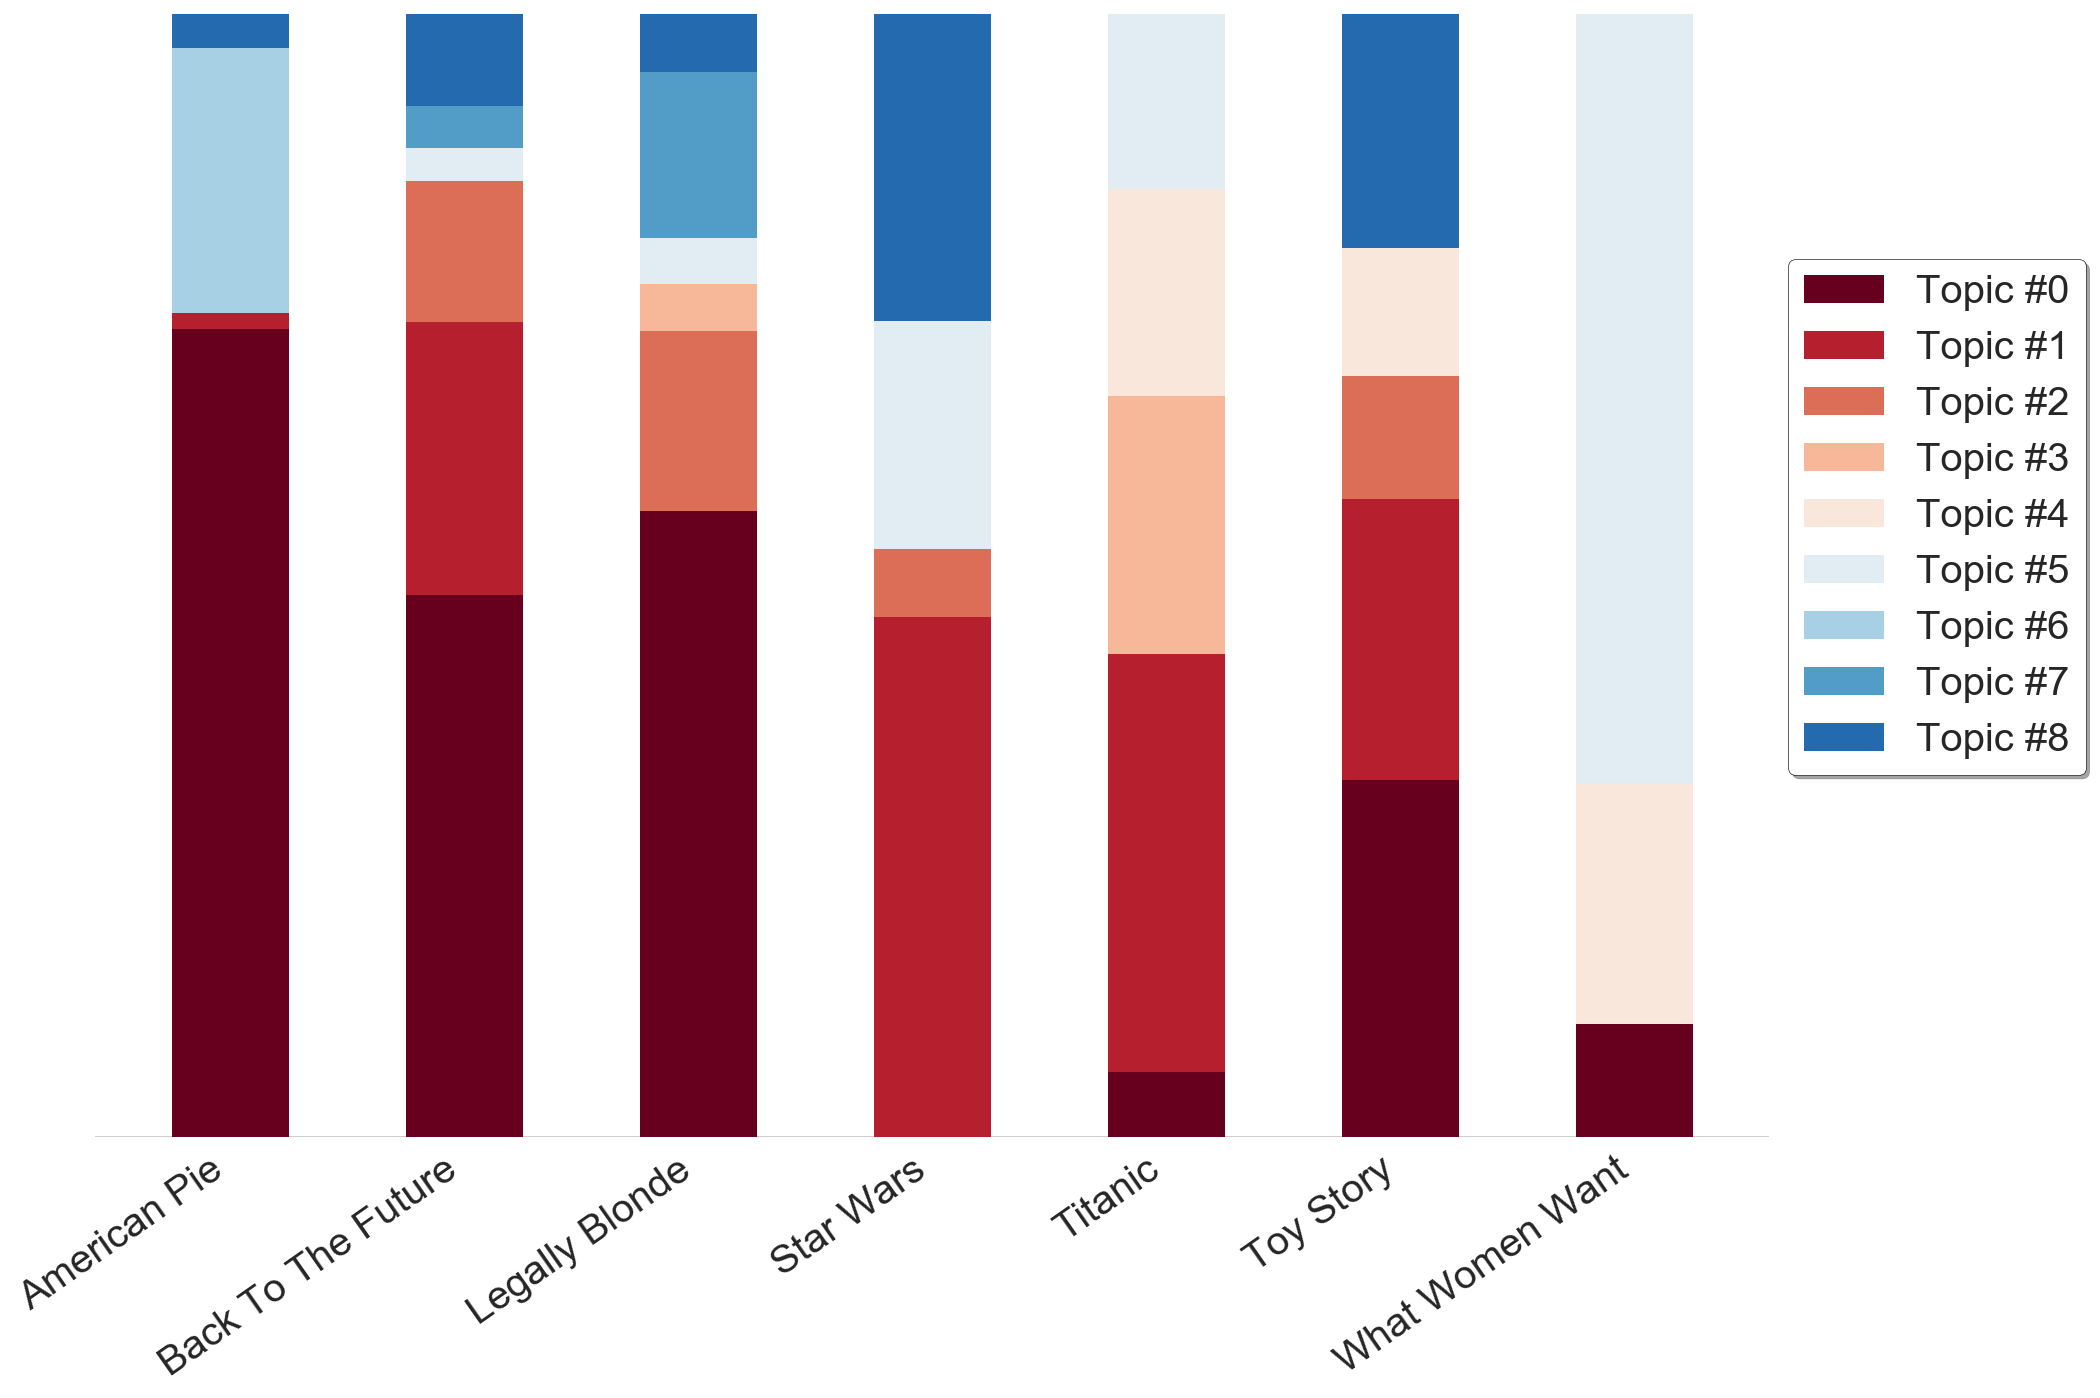

In [145]:
graphBars(docnames, doctopics_divided, file_name = 'topics_in_select_movies_no_title_new')

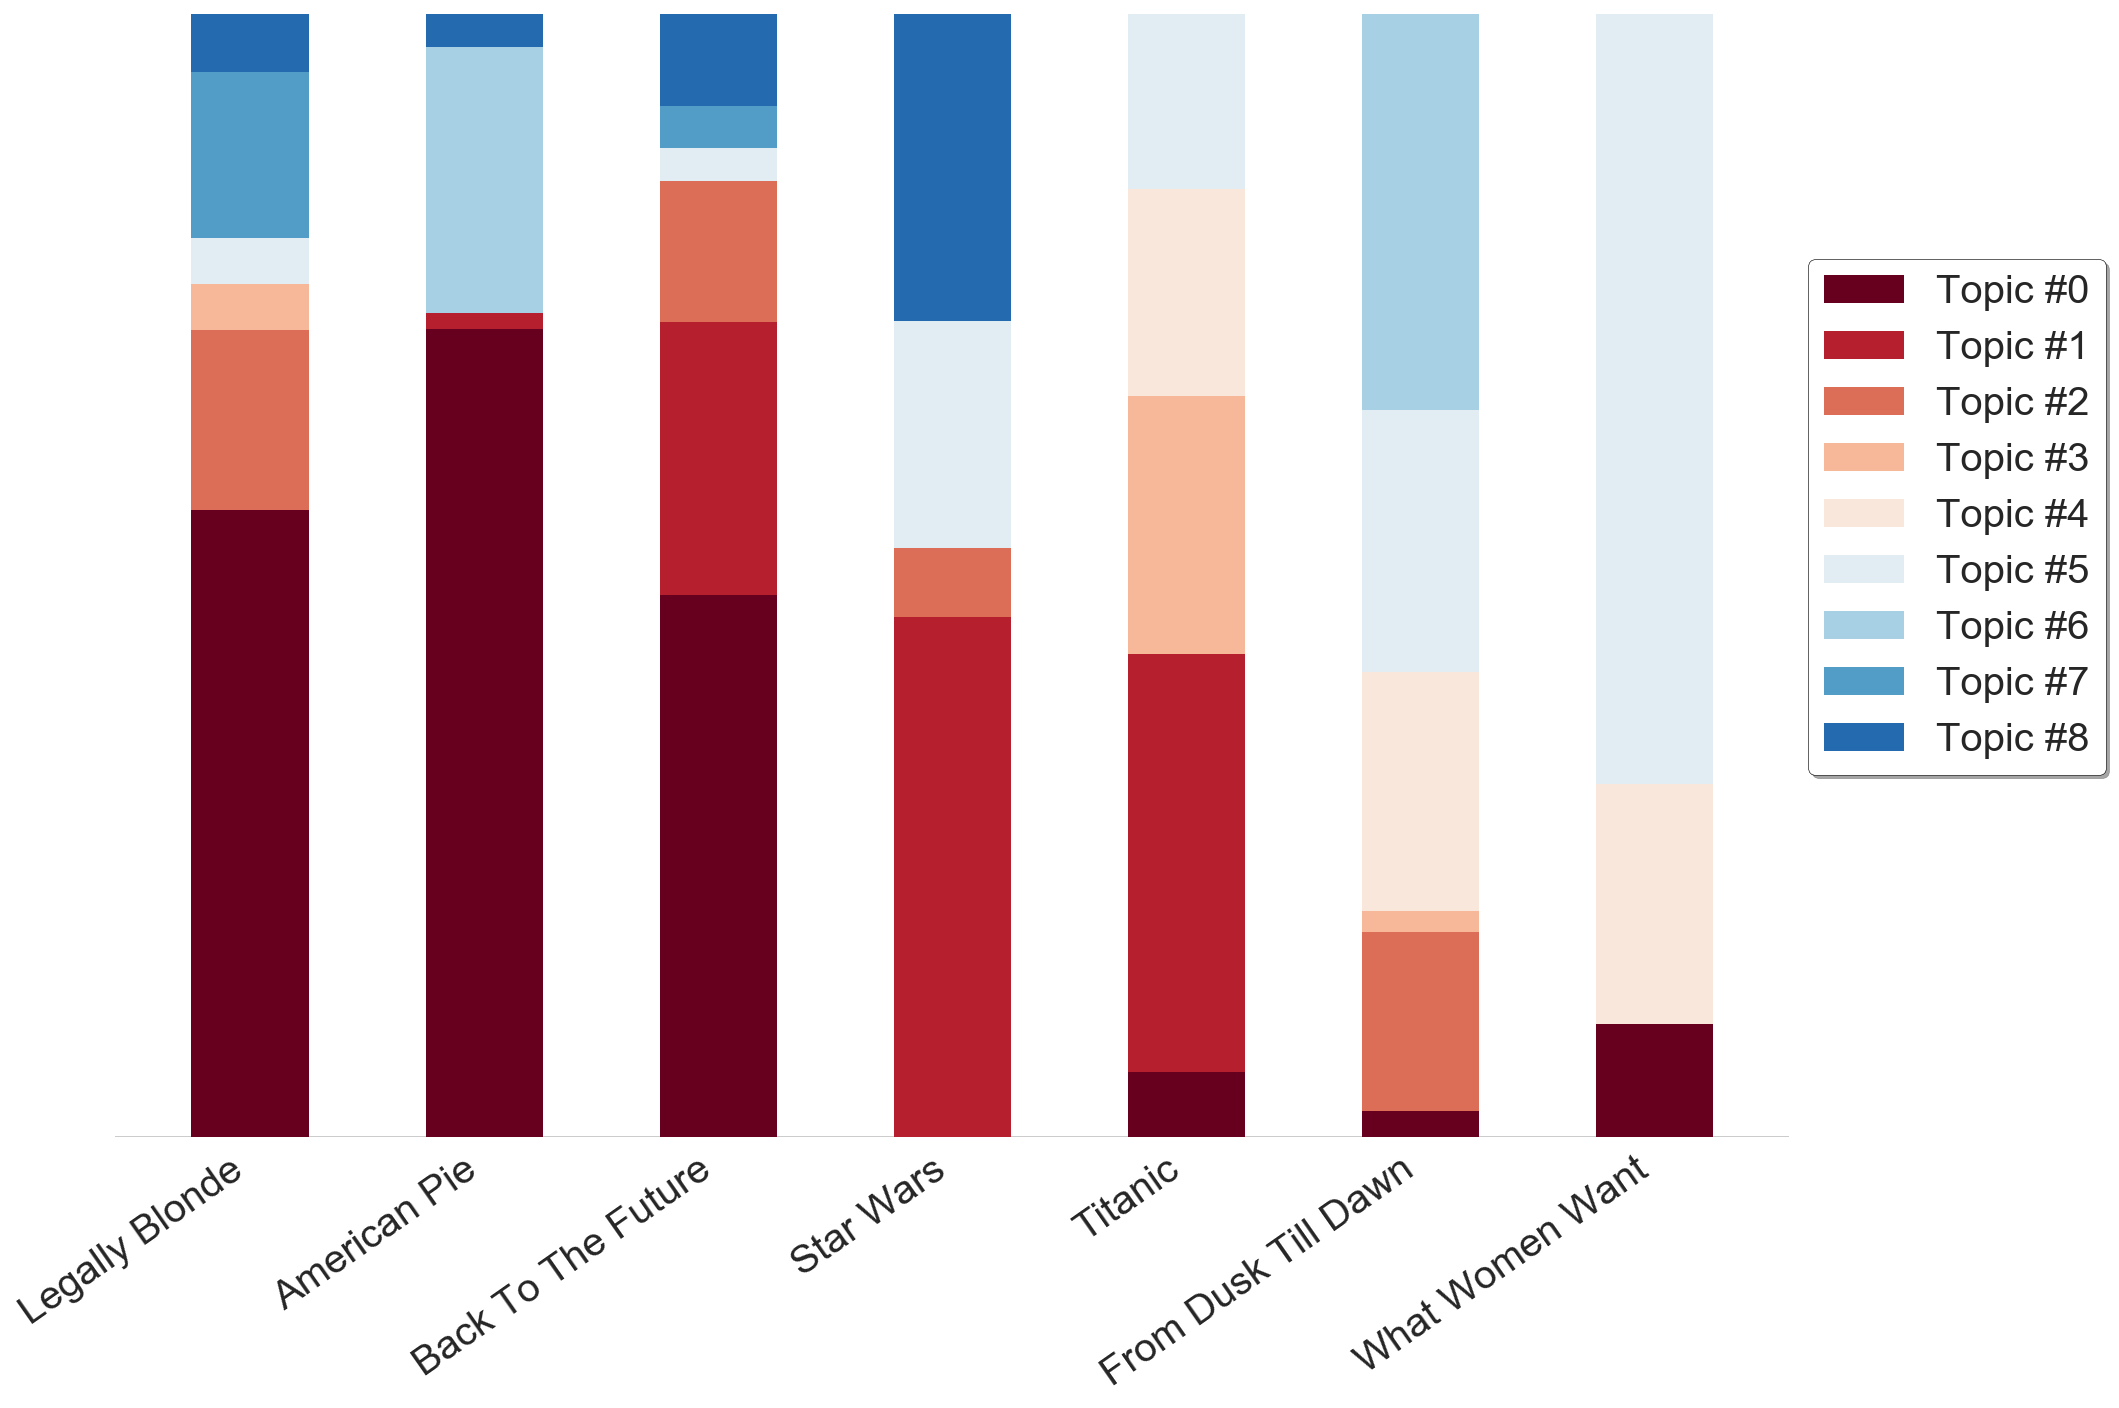

In [146]:
graphBars(wrongdocnames, wrongdoctopics_divided, file_name = 'topics_in_select_movies_wrong')

Topic  0
school, great, mom, home, kid, house, god, guess, thanks, baby, nice, year, girl, big, night, mother, fine, huh, movie, dad, party, actually, parent, stuff, someone, married, remember, woman, wanted, date, pretty, real, hello, show, sex, father, wow, story, dream, stop, trying, class, talking, book, getting, dinner, listen, um, person, alright, anyway, together, thank, whole, thinking, minute, play, fun, room, hate

Topic  1
ship, admiral, enterprise, commander, planet, crew, power, space, system, sir, shield, boat, warp, beam, command, signal, control, vessel, aboard, computer, torpedo, engine, data, mission, unit, radiation, transmission, starship, weapon, deck, human, scan, hour, thruster, starfleet, bridge, energy, meter, sector, force, federation, whale, shuttle, island, coordinate, carbon, ready, dr, shark, report, hull, course, air, transporter, fire, minute, second, surface, destroy, speed

Topic  2
kill, killed, cop, dead, car, killer, agent, alright, shit, police, murder, game, file, gun, someone, computer, phone, found, tape, real, night, shot, happened, year, remember, program, suspect, virus, body, die, left, system, knew, evidence, one, chief, partner, world, talking, house, check, detective, alive, victim, god, stop, question, dream, trying, already, line, might, somebody, goddamn, run, looking, kid, killing, blood, head

Topic  3
money, dollar, business, thousand, car, wife, hundred, hello, bank, thank, girl, hotel, course, drink, pay, minute, police, room, ask, listen, might, understand, husband, nice, gun, york, buy, wanted, matter, care, million, mind, guess, thanks, week, married, went, idea, happened, fine, suppose, talking, film, run, miss, picture, home, huh, looking, deal, big, woman, story, came, getting, pretty, knew, office, hour, paper

Topic  4
goin, nothin, mama, somethin, boy, doin, daddy, bout, baby, comin, guess, nobody, girl, cause, outta, damn, shit, tellin, folk, huh, hit, brother, money, kid, tryin, gettin, sheriff, reckon, thinkin, shot, fuckin, mister, git, big, outa, real, maam, run, somebody, home, sayin, fella, kill, head, lookin, makin, done, feelin, everybody, shoot, ol, hurt, dyou, beat, eat, truck, trouble, nigger, bet, woman

Topic  5
father, child, mother, dead, lord, perhaps, men, power, sword, kill, shall, die, world, god, vampire, woman, death, brother, war, dear, army, evil, course, stay, heart, blood, true, master, wish, family, afraid, understand, many, fight, killed, done, died, knew, beautiful, word, came, general, dream, live, without, daughter, land, fear, alone, stop, boy, others, mind, dark, enemy, every, peace, speak, princess, hand

Topic  6
fucking, fuck, shit, money, fuckin, fucked, cop, asshole, goddamn, gun, motherfucker, kill, car, bullshit, bitch, talking, kid, shut, girl, alright, deal, drug, god, problem, dead, stupid, saying, movie, cause, sex, whatever, care, bastard, huh, brother, head, phone, wife, lead, grand, shot, hate, real, tape, cool, big, business, dude, getting, black, coming, fucker, move, hit, outta, listen, bullet, done, million, fine

Topic  7
dr, doctor, nurse, patient, hospital, jury, miss, witness, court, starling, thank, trial, understand, objection, medical, testimony, correct, anesthetic, year, animal, wife, happened, heartbeat, minute, client, course, office, prior, question, hour, form, might, quite, nanobot, oxygen, truth, ape, brain, chart, anesthesiology, disallowed, admittance, woman, fine, god, expert, ago, lawyer, afraid, rebuttal, werewolf, read, scientist, book, disbarred, someone, child, file, island, called

Topic  8
sir, colonel, war, general, thank, president, officer, men, course, boy, plane, order, gentleman, senator, maam, army, eh, shall, country, base, chief, air, pilot, lieutenant, room, soldier, bomb, quite, best, command, letter, twenty, ambassador, doctor, committee, mission, enemy, admiral, morning, dear, ah, military, service, certainly, attack, young, great, every, private, fuel, party, perhaps, rather, minute, mister, matter, excuse, big, river, newspaper

# Topics for Wrong Swearing

Topic  0
get, go, back, come, take, money, let, look, could, make, thing, time, something, car, maybe, anything, sure, around, never, give, would, man, nothing, better, keep, place, help, gun, find, talk, little, wo, much, away, call, dollar, minute, need, day, put

Topic  1
must, father, would, come, man, never, go, could, child, time, life, nothing, mother, let, perhaps, back, shall, take, make, dead, lord, men, power, woman, brother, much, day, sword, old, world, friend, wo, believe, dear, die, death, god, find, people, thing

Topic  2
ship, admiral, enterprise, commander, planet, power, system, crew, get, sir, space, time, could, shield, warp, need, dr, beam, well, go, command, computer, back, signal, control, must, data, would, torpedo, vessel, aboard, mission, unit, thing, radiation, human, let, engine, starship, something

Topic  3
get, goin, mama, nothin, somethin, boy, man, daddy, doin, well, go, come, bout, back, baby, take, little, girl, time, comin, cause, make, outta, folk, guess, nobody, look, tellin, sure, brother, let, git, reckon, mean, around, day, mister, never, tryin, huh

Topic  4
well, would, mean, really, get, look, go, thing, come, could, little, sure, thank, time, something, hello, much, said, anything, course, sorry, huh, nice, great, fine, let, money, guess, thought, kind, please, never, make, take, maybe, listen, people, thanks, girl, eh

Topic  5
fucking, fuck, shit, man, get, fuckin, money, cop, fucked, go, mean, asshole, goddamn, gun, kill, need, motherfucker, bitch, look, time, car, bullshit, talking, alright, let, put, give, said, girl, call, movie, something, dead, sorry, drug, back, shut, make, well, take

Topic  6
get, go, really, thing, look, time, something, school, maybe, mean, could, back, come, mom, let, god, kid, sure, need, never, sorry, little, make, great, thought, house, dream, night, dad, feel, talk, take, life, home, even, said, would, well, call, baby

Topic  7
sir, colonel, general, war, get, well, officer, man, president, men, would, army, plane, thank, order, base, air, chief, soldier, lieutenant, pilot, country, maam, senator, boy, bomb, gentleman, command, must, let, take, mission, enemy, make, attack, best, shall, ambassador, military, put

Topic  8
would, could, dr, people, time, work, killed, call, get, need, something, file, said, make, told, thing, find, doctor, life, someone, never, witness, murder, name, year, kill, man, question, police, killer, believe, cop, agent, even, office, happened, hospital, take, lawyer, wrong

# Testing Workspace - Testing a Variety of Different Vectorizers, Stop Words, and Min/Max DF

In [147]:
# cv_test = CountVectorizer(ngram_range=(1, 1), stop_words='english', min_df=5)
# data_dtm_test = cv_test.fit_transform(data_df.script)
# data_dtm_test = pd.DataFrame(data_dtm_test.toarray(),
#                              columns=cv_test.get_feature_names())
# data_dtm_test.index = data_df.index

In [148]:
# tdm_test = data_dtm_test.transpose()
# sparse_counts_test = scipy.sparse.csr_matrix(tdm_test)
# corpus_test = matutils.Sparse2Corpus(sparse_counts_test)
# id2word_test = dict((v, k) for k, v in cv_test.vocabulary_.items())

# lda_test = models.LdaModel(corpus=corpus1, id2word=id2word1,
#                            num_topics=2, passes=100)
# lda_test.print_topics()

In [149]:
# tdm_test

In [150]:
# sk_cv_test = CountVectorizer(analyzer='word',
#                              min_df=3,
#                              stop_words=stop,
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              )

# sk_data_dtm_test = sk_cv_test.fit_transform(data_df.script)

# sk_lda_test = LatentDirichletAllocation(n_components=2,  # Number of topics
#                                         learning_method='online',
#                                         random_state=0,
#                                         n_jobs=-1  # Use all available CPUs
#                                         )
# sk_lda_output_test = sk_lda_test.fit_transform(sk_data_dtm_test)

In [151]:
# display_topics(sk_lda_test, sk_cv_test.get_feature_names(), 20)

In [152]:
# data_df

In [153]:
# with open(f'models/lda_cv_(1, 1)_man_0.85.pkl', 'rb') as handle:
#     lda_model = pickle.load(handle)

In [154]:
# with open(f'cv/cv_(1, 1)_man_0.85.pkl', 'rb') as handle:
#     vec = pickle.load(handle)

In [155]:
# dtm_lda = pd.read_pickle(f'dtm/dtm_cv_(1, 1)_man_0.85.pkl')

In [156]:
# texts = list(data_df.script)

# texts = [d.split() for d in texts]

In [157]:

# dictionary = Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

In [158]:
# coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, corpus=corpus, coherence='u_mass')

# print(f'The coherence score is: {coherence_model_lda.get_coherence()}')

In [159]:
# docs = docs would be matrix of points
# labels = max topics

# umap = UMAPVisualizer(metric ='euclidean')
# umap.fit(docs, labels)
# umap.show()

In [160]:
# cv = CountVectorizer(ngram_range = (2,3), stop_words = manstop, min_df = 3, max_df = 0.8)
# data_dtm = cv.fit_transform(data_df.script)
# data_dtm = pd.DataFrame(data_dtm.toarray(),
#                           columns=cv.get_feature_names(),
#                        index = data_df.index)


In [161]:
# nmf_model = NMF(n_components = num_features, random_state = random_state)
# doc_topic_nmf = nmf_model.fit_transform(data_dtm)

# # print(f'NMF using {vectorizer}, with n_gram of {n_range}, stop words of {stop}, and max_df of {max_docfreq}')

# print('The mean of individual topic weights over all documents is:')
# mean = np.mean(doc_topic_nmf, axis=0)
# print(mean)

# print('---')
# print('The variance of individual topic weights over all documents is:')
# variance = np.var(doc_topic_nmf, axis=0)
# print(variance)

# topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
#                               index=index_names,
#                               columns=cv.get_feature_names())
# print('---')
# print('The topics are:')
# display_topics(nmf_model, cv.get_feature_names(), 20)

# best_topic_nmf = [x.argmax() for x in doc_topic_nmf]
       
# # UMAP Visualization Option 1 -------------------------------------------
# plt.figure(figsize=(15,10))
# docs = doc_topic_nmf
# labels = best_topic_nmf

# umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1')
# umap.fit(docs, labels)
# umap.show()

In [162]:
# tf23, dtm23 = createCustomTFIDFvectorizer(data_df, n_range=(2,3), stop = 'man', min_docfreq = 3, max_docfreq = 1.0, file_mod = '')

In [163]:
# index_names = [f'component_{x}' for x in range(8)]
# performCustomNMF(tf23, dtm23, num_features = 8, index_names = index_names)

In [164]:
# tf22, dtm22 = createCustomTFIDFvectorizer(data_df, n_range=(2,2), stop = 'man', min_docfreq = 3, max_docfreq = 1.0, file_mod = '')

# index_names = [f'component_{x}' for x in range(8)]
# performCustomNMF(tf22, dtm22, num_features = 8, index_names = index_names)

In [165]:
# tf22, dtm22 = createCustomTFIDFvectorizer(data_df, n_range=(2,2), stop = 'man', min_docfreq = 1, max_docfreq = 1.0, file_mod = '')

# index_names = [f'component_{x}' for x in range(2)]
# performCustomNMF(tf22, dtm22, num_features = 2, index_names = index_names)

In [166]:
# tf, dtm = createCustomTFIDFvectorizer(data_df, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.85, file_mod = '')

# index_names = [f'component_{x}' for x in range(9)]
# doc_topic_nmf_selection = performCustomNMF(tf, dtm, num_features = 9, index_names = index_names)

# len(doc_topic_nmf_selection)

In [167]:
# tf, dtm = createCustomTFIDFvectorizer(data_df, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.8, file_mod = '')

In [168]:
# index_names = [f'component_{x}' for x in range(2)]
# performCustomNMF(tf, dtm, num_features = 2, index_names = index_names)

In [169]:
# performCustomNMF(tf, dtm)

In [170]:
# tf, dtm = createCustomTFIDFvectorizer(data_df, n_range=(1,1), stop = 'man', min_docfreq = 3, max_docfreq = 0.8, file_mod = '')

In [171]:
# performCustomLSA(tf, dtm)